# NYPD Fare Evasion Enforcement's Disparate Impact
Leena Kahlon, Dylan Fosgett, Woo Hyuk Chang and Rebecca Dorn with Dhawal Joharapurkar
University of California, Santa Cruz, Fall 2019

<img src="https://pbs.twimg.com/media/EJAwu4gWsAoPKwL?format=jpg&name=medium">

*Image from Twitter's @DecolonizeThisPlace*

## Introduction
***
On October 28, 2019, a video of around ten police officers tackling and pulling guns on a black teen for evading the \$2.75 subway fare in New York City went viral. Communities were enraged to see this fierceley violent attack on a teen of color over such a small fare. A few months before, the MTA calculated that they were losing millions annually due to those who evade paying the transit fare. The MTA decided to deploy 500 new officers to watch for turnstile hoppers, in hopes of losing less money. While in theory this plan makes sense, we can't help but wonder. What kind of disparate impact against communities of color is happening? What about against lower income communities?


## Setup: Installing Necessary Libraries
```pip install matplotlib
pip install numpy
pip install pandas
pip install folium
pip install twitter
pip install nltk```

Cooresponding files can be found on git: https://github.com/rebdorn/fare_evasion

## Project
***
We organize our project into distinct portions
1. Web Scraping
2. Data Wrangling
3. Data Visualization

Our goal is to create an easy-to-use visualization to answer the following research questions:
1. How has fare evasion enforcement in New York City changed in recent years?
2. What subway stations have an outstanding number of recent police sightings? What are the demographics around these stations?
3. What are the fare evasione enforcement trends around stations with outstanding numbers of recent police sightings?
4. What is the overlap between stations with more police sightings and stations with more fare evasion enforcement?

# Web Scraping
***
To get recent police sightings, we scrape twitter account @unfarenyc. This is an account where people send information about police sightings at subway stations, and they post the number of cops and which subway station. We scrape the twitter account these sightings using nltk and bear's python twitter wrapper. Note that to run this code on your account, you must posess a secret key given by the Twitter API.

We begin by running some import statements. Make sure to run this cell, or else the code won't work!

In [2]:
from itertools import permutations
from datetime import datetime, date
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import twitter
import nltk

**Scraping the Twitter API:** We use bare's Python wrapper for the twitter API to make our life easier. The operations we do occur as follows:
- Connect to the Twitter API using our given keys. (Note: a key is not provided in this demo, make sure to plug your own key into git.ignore before running thic cell!)
- Get the entirety of @UnfareNYC's timeline. The function "GetUserTimeine" requires we specify the number of tweets to request, and the maximum is 200. Because of this, we need to recursively find the earliest tweet out of the 200 we get, and use that as an end point for the 200 tweets beforehand.
- The twitter API gives us a hefty amount of information. So, store only our most desired information in our dataframe: ID, User, created_at and text.

In [ ]:
with open("Twitter_Keys.txt", 'r') as in_file:
    CONSUMER_KEY = in_file.readline()
    CONSUMER_SECRET = in_file.readline()
    ACCESS_TOKEN_KEY = in_file.readline()
    ACCESS_TOKEN_SECRET = in_file.readline()

# connect to twitter API with our given user credentials
api = twitter.Api(consumer_key = CONSUMER_KEY[1:-2],
                      consumer_secret = CONSUMER_SECRET[1:-2],
                      access_token_key = ACCESS_TOKEN_KEY[1:-2],
                      access_token_secret = ACCESS_TOKEN_SECRET[1:-1])

In [ ]:
# Scrape @unfarenyc's twitter timeline
statuses_list = api.GetUserTimeline(count=200,screen_name='unfarenyc') # Load @unfarenyc's timeline

# To get earlier tweets we continuously find the minimum and get the 200 previous
earliest_tweet = min(statuses_list, key=lambda x: x.id).id # Find the last tweet we were allowed to get
while True: # While there are more tweet to get
    nexttweets = api.GetUserTimeline(screen_name='unfarenyc', max_id=earliest_tweet, count=200)
    new_earliest = min(nexttweets, key=lambda x: x.id).id
    if not nexttweets or new_earliest == earliest_tweet:
        break
    else:
        earliest_tweet = new_earliest
        statuses_list += nexttweets

In [ ]:
# Store the desired information into a dataframe
tweets = []
for s in statuses_list:
    tweets.append([s.id,s.user.screen_name,s.created_at,s.text,s.retweet_count])
tweetsdf = pd.DataFrame(tweets,columns=['ID','user','created_at','text','retweets'])

We define two functions. One to process subway station names such that they are all lowercase, we separate "2nd" to "2" and "nd" (Same with formats of 1st, 17th) and change some common phrases to be short and don't include vowels. Secoond function is to change unigrams to match station names-- we remove some specific punctuation and change park -> pk, etc.

In [ ]:
# Our NLP protocol for getting unigrams into a usable form
def process_unigram(unigram, st_bool = 1):
    if st_bool == 1: # If we signaled to check if this is a condensed street name
        if unigram[0].isdigit() & unigram.endswith('st'): # Are we of form "1"st?
            unigram = unigram[:-2] + " " + 'st' # Shorten unigram to only that street number
    if unigram[0].isdigit() & unigram.endswith('nd'): # Are we of form "2"nd?
        unigram = unigram[:-2] # Shorten unigram to just that number
    elif unigram[0].isdigit() and unigram.endswith('th'): # Are we of form "10"th?
        unigram = unigram[:-2] # Shorten unigram to only that number
    elif unigram[0].isdigit() and unigram.endswith('rd'): # Are we of form "10"th?
        unigram = unigram[:-2] # Shorten unigram to only that number
    elif unigram == 'park': # Shorten park to pk
        unigram = 'pk' 
    elif unigram == 'parkway': # Shorten parkway to pkwy
        unigram = 'pkwy' 
    elif unigram == 'heights': # Shorten heights to hts
        unigram = 'hts' 
    elif unigram == 'ave': # Shorted ave to av
        unigram = 'av'
    elif unigram == 'place': # Shorten place to pl
        unigram = 'pl'
    elif unigram == 'street': # Shorten street to st
        unigram = 'st'
    elif unigram == 'avenue': # Shorten avenue to av
        unigram = 'av'
    elif unigram == 'avnue': # For same reason many tweets spell avenue like this?
        unigram = 'av' # Anyways, shorten avnue to av
    return unigram

# Our NLP protocol for processing subway names (removing punct, etc.)
def process_stations(df_col):
    processed_tweets = df_col.str.replace(" - "," ") # Remove odd hyphens
    processed_tweets = processed_tweets.str.replace("-"," ")
    processed_tweets = processed_tweets.str.replace("/"," ")
    processed_tweets = processed_tweets.str.replace(".","")
    processed_tweets = processed_tweets.str.replace("'","")
    processed_tweets = processed_tweets.str.replace("(","")
    processed_tweets = processed_tweets.str.replace(")","")
    processed_tweets = processed_tweets.str.lower()
    processed_tweets = processed_tweets.str.replace("ave","av") # Shorten common phrases
    processed_tweets = processed_tweets.str.replace("avenue", "av")
    processed_tweets = processed_tweets.str.replace("street","st")
    processed_tweets = processed_tweets.str.replace("square","sq")
    processed_tweets = processed_tweets.str.replace("place", "pl")
    processed_tweets = processed_tweets.str.replace("heights","hts")
    processed_tweets = processed_tweets.str.replace("park","pk")
    processed_tweets = processed_tweets.str.replace("jay st metrotech","jay st")
    return processed_tweets

Process the subway names, create a list of subway station names to later check tweets

In [ ]:
# Read the CSV file of Subway Station names and process the names
stations = pd.read_csv("Stations.csv")

# Process the station names, convert to list for easy searching
station_names = list(process_stations(stations['Stop Name']))

# Process the tweets such that it sepearates hyphens, we process unigrams more later.
processed_tweets = process_stations(tweetsdf['text'])

# Add new empty column to tweetsdf to store station names
tweetsdf['station_referral'] = np.nan

Loop through tweets, check fourgram -> unigram if this is a station name (Bigger name first helps ensure we get right station)

In [ ]:
# Loop through each tokened tweet and look for the subway station
for i, row in enumerate(processed_tweets.apply(nltk.tokenize.word_tokenize)):
    found = 0 # At the beginning of each tweet, reset bool found
    #print(row)
    for fourgram in nltk.ngrams(row,4): # Check each combo of 4 tokens in tweet
        if found == 1: # If we've found the station
            break # Leave the loop
        one, two, three, four = fourgram # Unpack fourgram to permute versions of tuple
        one = process_unigram(one) # Process the unigrams
        two = process_unigram(two)
        three = process_unigram(three)
        four = process_unigram(four)
        for ordering in permutations([one, two, three, four]): # For each possible ordering of these unigrams
            perm_one, perm_two, perm_three, perm_four = ordering # Unpack this permutation
            if perm_one+" "+perm_two+" "+perm_three+" "+perm_four in station_names[:]: # If this permutation is a station name
                tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two+" "+perm_three+" "+perm_four # Put the data in our dataframe
                found = 1 # Signal that for this tweet we have found the station
                break # Break out of the loop!
    
    if found != 1: # If we have checked all fourgrams and did not find the subway station
        for trigram in nltk.trigrams(row): # Check each trigram for a subway station
            if found == 1: # If we found the station in the last iteration of the loop
                break # break out of this for loop
            one, two, three = trigram # Unpack our trigram
            one = process_unigram(one) # Process individual unigrams
            two = process_unigram(two)
            three = process_unigram(three)
            for ordering in permutations([one, two, three]): # For each ordering of trigram
                perm_one, perm_two, perm_three = ordering # Unpack the ordering
                if perm_one+" "+perm_two+" "+perm_three in station_names[:]: # If this ordering is a station name
                    tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two+" "+perm_three # Store this name with this tweet
                    found = 1 # Set found to 1 to indicate this tweet's station has been found
                    break # Break out of the loop
                
    if found != 1: # If we still have not found the subway station
        for bigram in nltk.bigrams(sorted(row, reverse = True)): # Loop through bigrams to find the subway
            if found == 1: # If we found it in the last iteration of this loop
                break # Exit the loop
            one, two = bigram # Unpack the bigram
            one = process_unigram(one) # Process the unigrams
            two = process_unigram(two)
            for ordering in permutations([one, two]): # For each ordering of these unigrams
                perm_one, perm_two = ordering # Unpack the ordering
                if perm_one+" "+perm_two in station_names[:]: # If this station is a subway station name
                    tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two # Store this station with this tweet
                    found = 1 # Signal we've found the station
                    break # Exit the for loop of ordering
                
    if found != 1: # If we have still not found the subway station
        for unigram in row: # For each unigram in row
            if found == 1: # If we found the last unigram
                break # break out of this for loop, onto the next tweet!
            unigram = process_unigram(unigram, st_bool = 0) # Process this unigram, check if it has a street name
            if unigram[0].isdigit() and unigram.endswith('st'): # If this unigram is of form 72st
                if unigram[:-2] + " " + "st" in station_names[:]: # Separate station name and st
                    tweetsdf.loc[i,'station_referral'] = unigram[:-2] + " " + "st" # Store 72 st
                    found = 1 # Indicate we've found the station
                    break # Break out of this for loop
        unigram = process_unigram(unigram) # Process the unigram
        if found != 1: # If we did not find it earlier
            for unigram in sorted(row, reverse = True): # Reverse the row: check alphabetic names first!
                if found == 1: # If we've found the station name
                    break # Break out of the loop
                if unigram in station_names[:]: # If this unigram by itself is a subway station name
                    tweetsdf.loc[i,'station_referral'] = unigram # Store the name
                    found = 1 # Indicate we've found the station
                    break # Break out of the for loop
                elif unigram+" st" in station_names[:]: # If this unigram street is a station
                    tweetsdf.loc[i,'station_referral'] = unigram+" st" # Store the name
                    found = 1 # Indicate the station has been found
                    break # Break out of the for loop
                elif unigram+" av" in station_names[:]: # If this unigram avenue is a station
                    tweetsdf.loc[i,'station_referral'] = unigram+" av" # Store the name
                    found = 1 # Indicate the station has been found
                    break # Break out of the for loop

For our project, we map out 24 specific stations such that each transit district has one high count station and one low count station. Let's take a look at the sightings counters for Transit District 2. While we're only mapping transit district 2 here, feel free to plug in the subway station names of other districts to see how those counts turned out!

In [ ]:
# Store a list of the processed versions of all stations in transit district 2
transit_district_2_stations = ['34 st penn station', '34 st herald sq', '28 st', '23 st', 'franklin st',
                               '6 av', '8 av', '18 st', '14 st', 'christopher st sheridan sq', 'whitehall st'
                               'houston st', 'spring st', 'canal st', 'pk pl', 'chambers st', 'broad st'
                               'world trade center', 'brooklyn bridge city hall', 'fulton st', 'rector st',
                               'cortlandt st', 'bowling green', 'south ferry', 'wall st']

# Get a counter of sightings for all stations
station_referral_counts = tweetsdf['station_referral'].value_counts()
transit_district_2_sightings = station_referral_counts[transit_district_2_stations]
transit_district_2_sightings.plot.bar()


**Datetime:** We convert when tweets were created to datetime objects, to help in plotting trends

In [ ]:
# A simple mapping of the first 3 letters of months to their numerical representation
month_number = { 'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4,
                'May': 5, 'Jun' : 6, 'Jul' : 7, 'Aug' : 8,
                'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}

# Create a new column in the tweets dataframe for our datetime objects and populate
tweetsdf['created_at_datetime'] = np.nan
for k, instance in enumerate(tweetsdf['created_at']): # for each tweet's creation time/day
    for i, chunk in enumerate(instance.split(" ")): # parse through the datetime, split by space
        if i == 1: # If this is the first chunk
            this_month = month_number[chunk] # Convert to the month number
        elif i == 2: # If this is the second chunk
            this_day = int(chunk) # Store as the day of the month
        elif i == 5: # If this is the fifth chunk
            this_year = int(chunk) # Store as the year
    tweet_datetime = date(year = this_year, month = this_month, day = this_day) # Convert data to datetime
    tweetsdf.loc[k,'created_at_datetime'] = tweet_datetime # Store datetime object in our dataframe

**Weekly Bins:** We want to ultimately be able to look at recent trends in police sightings for a subway station in comparison to the average number of police sightings per subway station. We create weekly bins so we can track the data week by week.

In [ ]:
# create a series of data ranges we check (Every sunday since its been created)
weekly_bins = pd.date_range(start = '2019-08-04', end = '2019-11-30',freq = 'W-SUN')

# Plot average sightings per week
averagecount_array = [np.nan] * len(weekly_bins)
for i, week in enumerate(weekly_bins):
    daysofweek = pd.date_range(start = week, freq = 'D', periods = 7)
    view = np.where((daysofweek[0] >= tweetsdf['created_at_datetime']) & (tweetsdf['created_at_datetime'] <= daysofweek[6]), 1, 0)
    averagecount_array[i] = np.count_nonzero(view)
averagecount_array

# Get average number of police sightings
average_plot = []
for i, item in enumerate(averagecount_array):
    average_plot.append(averagecount_array[i] / len(station_names))

In [ ]:
# Function to easily get weekly police counts of a station
def weeklycounts_fromstation(station_name):
    # Get the tweets about our station name
    station_tweets = tweetsdf.loc[tweetsdf['station_referral'] == station_name]
    count_array = [np.nan] * int(len(weekly_bins))
    for i, week in enumerate(weekly_bins):
        daysofweek = pd.date_range(start = week, freq = 'D', periods = 7)
        view = np.where((daysofweek[0] >= station_tweets['created_at_datetime']) & (station_tweets['created_at_datetime'] <= daysofweek[6]), 1, 0)
        count_array[i] = np.count_nonzero(view)
    return count_array 

Finally, we create create 24 graphs, each showing the number of police sightings compard to average sightings.

In [ ]:
# Create a list of the station names we want to look up
chosen_stations = ['59 st columbus circle', '79 st', 'franklin st', 'wall st', '125 st', '103 st', '14 st union sq',
                   'spring st', 'tremont av', 'fordham rd', '3 av 149 st', 'freeman st', 'flushing main st', 'elmhurst av', 
                   'broad channel', 'beach 98 st', 'jay st', 'franklin av', 'union st', 'kingston av', 'atlantic av',
                   'montrose av', 'newkirk av', 'brighton beach']

xindex = [] # New list to be xindex labels
for date in weekly_bins: # For each sunday of weeks we want to look at
    name = str(date) # convert the name to a string
    xindex.append(name[5:-9]+"-19") # Get a label of the date

for i, station in enumerate(chosen_stations): # Loop through each station
    fig, axes = plt.subplots(1,1) # Create a new subplot (Don't want to layer!)
    count_array = weeklycounts_fromstation(station) # Get the array values for weekly sightings
    axes.plot(count_array,'-or', label = station) # Plot this station's sightings
    axes.plot(average_plot, '-o', label = 'average over all') # Plot the average number of sightings
    axes.set_title(station.upper()+" WEEKLY POLICE SIGHTING COUNT") # Create a title for our graph
    axes.set_xticks(np.arange(0,len(average_plot),2))
    axes.set_xticklabels(xindex[::2], rotation = 30) # Add tick labels of weekly dates
    axes.set_xlabel("WEEK") # Add an x-axis label
    axes.set_ylabel("TOTAL POLICE SIGHTINGS") # Add a y-axis label
    axes.legend(loc='best') # Place our legend on the graph
    filename = str(station).replace(" ","") # Process the station name so we can save it as file
    plt.savefig("sightings/"+filename+".png",bbox_inches="tight") # Save the plot to a file for later use


## Data Wrangling
***
We further split our data wrangling into three parts:
1. Wrangling at the Community District level
2. Wrangling at the Transit District level

### Wrangling at the Community District level

In [3]:
# Run these import statements or the code won't work!
from pandas import Series, DataFrame

In [4]:
# Read in CSV file with community district information
# Note that we have yet to properly account for the hierarchichal indexing: it'll start pretty ugly.
district_demo = pd.read_csv('sf1_dp_cd_demoprofile.csv')
district_demo

,Table SF1-DP CD: Demographic Profile - New York City Community Districts,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,2000 and 2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,New York City,NaN,NaN,NaN,NaN,2000,NaN,2010,NaN,Change 2000-2010,NaN
3,NaN,NaN,NaN,NaN,NaN,Number,Percent,Number,Percent,Number,Percent
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4374,NaN,By Age of Householder:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4375,NaN,NaN,15 to 24 years,NaN,NaN,804,1.5,691,1.2,-113,-14.1
4376,NaN,NaN,25 to 44 years,NaN,NaN,"21,365",40.2,"17,963",31.4,"-3,402",-15.9
4377,NaN,NaN,45 to 64 years,NaN,NaN,"21,161",39.8,"25,713",44.9,"4,552",21.5


In [5]:
# Create some empty lists to hold data computations later.
data_numbers = {'Total': [], 
                'White': [], 
                'Black': [], 
                'Asian': [], 
                'Other': [], 
                'Two or more races': [], 
                'Hispanic': [], 
                'Female': [], 
                'Male': [], 
                'Under 5 years': [], 
                '5 to 9 years': [], 
                '10 to 14 years': [], 
                '15 to 19 years': [], 
                '20 to 24 years': [], 
                '25 to 44 years': [], 
                '45 to 64 years': [], 
                '65 years and over': []}
data_percentages = {'Total': [], 
                    'White': [], 
                    'Black': [], 
                    'Asian': [], 
                    'Other': [], 
                    'Two or more races': [], 
                    'Hispanic': [], 
                    'Female': [], 
                    'Male': [], 
                    'Under 5 years': [], 
                    '5 to 9 years': [], 
                    '10 to 14 years': [], 
                    '15 to 19 years': [], 
                    '20 to 24 years': [], 
                    '25 to 44 years': [], 
                    '45 to 64 years': [], 
                    '65 years and over': []}

# Turn these empty lists into pandas dataframe objects
frame_numbers = pd.DataFrame(data_numbers)
frame_percentages = pd.DataFrame(data_percentages)

In [6]:
# Rename the columns in the dataframe
district_demo.rename(columns = {'Table SF1-DP CD: Demographic Profile - New York City Community Districts': 'Districts',
                                'Unnamed: 1': 'Category', 'Unnamed: 5': '2000 Number', 'Unnamed: 6': '2000 Percent',
                                'Unnamed: 7': '2010 Number', 'Unnamed: 8': '2010 Percent', 'Unnamed: 9': 'Change Number', 
                                'Unnamed: 10': 'Change Percent'})

,Table SF1-DP CD: Demographic Profile - New York City Community Districts,Category,Unnamed: 2,Unnamed: 3,Unnamed: 4,2000 Number,2000 Percent,2010 Number,2010 Percent,Change Number,Change Percent
0,2000 and 2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,New York City,NaN,NaN,NaN,NaN,2000,NaN,2010,NaN,Change 2000-2010,NaN
3,NaN,NaN,NaN,NaN,NaN,Number,Percent,Number,Percent,Number,Percent
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4374,NaN,By Age of Householder:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4375,NaN,NaN,15 to 24 years,NaN,NaN,804,1.5,691,1.2,-113,-14.1
4376,NaN,NaN,25 to 44 years,NaN,NaN,"21,365",40.2,"17,963",31.4,"-3,402",-15.9
4377,NaN,NaN,45 to 64 years,NaN,NaN,"21,161",39.8,"25,713",44.9,"4,552",21.5


In [7]:
# List of categories given to us in the csv file
categories = ['Total', 'White', 'Black', 'Asian', 'Other', 'Two or more races', 'Hispanic', 'Female', 'Male', 
             'Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 44 years', 
             '45 to 64 years', '65 years and over']

row_index_start = 78 # Initialize the row we begin extracting information from
dfcolumn = 0 # Initialize the column we begin on as 0
for i in range(0, 17):
    count = 1 
    column_index = 7
    numbers = []
    row_index = row_index_start
    while(count < 60): 
        if(row_index <= 4378):
            numbers.append(district_demo.iloc[row_index, column_index]) 
            row_index = row_index + 73 
            count = count + 1 
    frame_numbers[categories[dfcolumn]] = numbers
    dfcolumn = dfcolumn + 1
    if row_index_start == 84 or row_index_start == 87:
        row_index_start = row_index_start + 2 
    else:
        row_index_start = row_index_start + 1

row_index_start = 78
dfcolumn = 0
for i in range(0, 17):
    count = 1
    column_index = 8
    numbers = []
    row_index = row_index_start
    while(count < 60):
        if(row_index <= 4378):
            numbers.append(district_demo.iloc[row_index, column_index])
            row_index = row_index + 73
            count = count + 1
    frame_percentages[categories[dfcolumn]] = numbers
    dfcolumn = dfcolumn + 1
    if row_index_start == 84 or row_index_start == 87:
        row_index_start = row_index_start + 2
    else:
        row_index_start = row_index_start + 1
    

In [8]:
districts = ['Bronx_1', 'Bronx_2', 'Bronx_3', 'Bronx_4', 'Bronx_5', 'Bronx_6', 'Bronx_7', 'Bronx_8', 'Bronx_9', 'Bronx_10', 'Bronx_11', 'Bronx_12', 
                       'Brooklyn_1', 'Brooklyn_2', 'Brooklyn_3', 'Brooklyn_4', 'Brooklyn_5', 'Brooklyn_6', 'Brooklyn_7', 'Brooklyn_8', 'Brooklyn_9',
                       'Brooklyn_10', 'Brooklyn_11', 'Brooklyn_12', 'Brooklyn_13', 'Brooklyn_14', 'Brooklyn_15', 'Brooklyn_16', 'Brooklyn_17', 'Brooklyn_18',
                       'Manhattan_1', 'Manhattan_2', 'Manhattan_3', 'Manhattan_4', 'Manhattan_5', 'Manhattan_6', 'Manhattan_7', 'Manhattan_8', 'Manhattan_9', 
                       'Manhattan_10', 'Manhattan_11', 'Manhattan_12', 'Queens_1', 'Queens_2', 'Queens_3', 'Queens_4', 'Queens_5', 'Queens_6', 'Queens_7',
                       'Queens_8', 'Queens_9', 'Queens_10', 'Queens_11', 'Queens_12', 'Queens_13', 'Queens_14', 'StatenIsland_1', 'StatenIsland_2', 'StatenIsland_3']
frame_numbers.index = districts
frame_percentages.index = districts

In [9]:
# Look at the first five rows of our totals dataframe
frame_numbers.head()

,Total,White,Black,Asian,Other,Two or more races,Hispanic,Female,Male,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 44 years,45 to 64 years,65 years and over
Bronx_1,"91,497","1,428","23,680",542,393,567,"64,887","48,615","42,882","7,609","7,572","7,462","8,910","8,135","25,332","18,343","8,134"
Bronx_2,"52,246",694,"11,536",341,236,350,"39,089","27,163","25,083","4,537","4,248","4,299","4,598","4,744","15,135","10,606","4,079"
Bronx_3,"79,762",918,"31,387",380,429,635,"46,013","43,395","36,367","6,842","6,733","6,874","7,709","6,773","21,608","16,846","6,377"
Bronx_4,"146,441","2,193","47,344","2,258",926,"1,382","92,338","77,447","68,994","12,372","11,449","11,262","12,658","12,067","41,853","32,447","12,333"
Bronx_5,"128,200","1,791","36,795","1,949",944,"1,121","85,600","67,595","60,605","10,973","10,302","10,217","11,729","11,343","36,496","28,672","8,468"


In [10]:
# Look at the first five rows of the percentages dataframe
frame_percentages.head()

,Total,White,Black,Asian,Other,Two or more races,Hispanic,Female,Male,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 44 years,45 to 64 years,65 years and over
Bronx_1,100.0,1.6,25.9,0.6,0.4,0.6,70.9,53.1,46.9,8.3,8.3,8.2,9.7,8.9,27.7,20.0,8.9
Bronx_2,100.0,1.3,22.1,0.7,0.5,0.7,74.8,52.0,48.0,8.7,8.1,8.2,8.8,9.1,29.0,20.3,7.8
Bronx_3,100.0,1.2,39.4,0.5,0.5,0.8,57.7,54.4,45.6,8.6,8.4,8.6,9.7,8.5,27.1,21.1,8.0
Bronx_4,100.0,1.5,32.3,1.5,0.6,0.9,63.1,52.9,47.1,8.4,7.8,7.7,8.6,8.2,28.6,22.2,8.4
Bronx_5,100.0,1.4,28.7,1.5,0.7,0.9,66.8,52.7,47.3,8.6,8.0,8.0,9.1,8.8,28.5,22.4,6.6


In [11]:
# Read in csv files that have information about median income
household_income = pd.read_csv('sub-borougharea-medianhouseholdincome2018.csv')
nyc_household_income = pd.read_csv('city-medianhouseholdincome2018.csv')

In [12]:
# Let's preview the data we just got!
household_income.head()

,short_name,long_name,Sub-Borough Area,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,hh_inc_med_adj,Median household income (2018$),Upper East Side,115949.576271,102540,119328.305945,124016.261968,127876.003868,114178.750964,108469.600094,116227.666528,107603.656250,114737.589367,121176.811121,107597.315657,121534.985328,133852.964651,121698
1,hh_inc_med_adj,Median household income (2018$),Morningside Heights/Hamilton Heights,46379.830508,34630,35661.361314,50479.011298,43606.014424,44616.799637,42339.464544,43618.100122,43779.223285,48584.214645,44411.588345,51127.444957,50947.213160,51002.475674,60021
2,hh_inc_med_adj,Median household income (2018$),Central Harlem,33084.279096,33130,33485.376017,37657.892267,38480.946964,36366.839793,40143.420084,39049.279221,39911.666750,39332.970440,42654.473058,48354.886678,47424.941826,49994.614252,47708
3,hh_inc_med_adj,Median household income (2018$),East Harlem,35557.870056,33350,33491.575406,37014.002719,35204.664029,32321.586374,34734.538719,34133.599093,33601.157838,28704.108043,32955.112554,31568.306554,35766.119807,37471.248212,32555
4,hh_inc_med_adj,Median household income (2018$),Washington Heights/Inwood,46379.830508,39340,40279.905605,42752.336723,43961.148175,42858.194751,46773.588461,41513.747168,39285.490930,39913.637040,47484.174142,47582.981248,54061.150384,57457.272687,53995


In [13]:
nyc_household_income.head()

,short_name,long_name,City,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,hh_inc_med_adj,Median household income (2018$),New York City,59200.761655,53780,57629.513729,58638.562929,59323.584311,57810.958104,55375.993353,54636.95614,55137.055977,55640.645645,55727.158421,58551.389833,61152.448868,62040.035897,63799


In [14]:
for i in range(5, 40):
    x, y = 0, 0
    if i < 13:
        x, y = 5, 1
    elif i > 13 and i < 17:
        x, y = 6, 1
    elif i > 23 and i < 40:
        x, y = 13, 1
    else: 
        y = 0
        
    if y == 1:
        a, b = household_income.iloc[i].copy(), household_income.iloc[i-x].copy()
        household_income.iloc[i], household_income.iloc[i-x] = b, a

a, b = household_income.iloc[29].copy(), household_income.iloc[35].copy()
household_income.iloc[29], household_income.iloc[35] = b, a

a, b = household_income.iloc[36].copy(), household_income.iloc[37].copy()
household_income.iloc[36], household_income.iloc[37] = b, a

a, b = household_income.iloc[37].copy(), household_income.iloc[38].copy()
household_income.iloc[37], household_income.iloc[38] = b, a

a, b = household_income.iloc[38].copy(), household_income.iloc[27].copy()
household_income.iloc[38], household_income.iloc[27] = b, a

a, b = household_income.iloc[39].copy(), household_income.iloc[28].copy()
household_income.iloc[39], household_income.iloc[28] = b, a

for i in range(28, 8, -1):
    a, b = household_income.iloc[i].copy(), household_income.iloc[i-1].copy()
    household_income.iloc[i], household_income.iloc[i-1] = b, a

for i in range(28, 52, 2):
    a, b = household_income.iloc[i].copy(), household_income.iloc[i+1].copy()
    c, d = household_income.iloc[i+2].copy(), household_income.iloc[i+3].copy()
    
    household_income.iloc[i], household_income.iloc[i+1] = c, d
    household_income.iloc[i+2], household_income.iloc[i+3] = a, b

a, b = household_income.iloc[52].copy(), household_income.iloc[53].copy()
household_income.iloc[52], household_income.iloc[53] = b, a

In [15]:
household_income.drop(['short_name', 'long_name', '2000'], axis=1, inplace=True)
districts1 = ['Bronx_1', 'Bronx_3', 'Bronx_4', 'Bronx_5', 'Bronx_7', 'Bronx_8', 'Bronx_9', 'Bronx_x10', 'Bronx_x11', 'Bronx_x12', 
                       'Brooklyn_1', 'Brooklyn_2', 'Brooklyn_3', 'Brooklyn_4', 'Brooklyn_5', 'Brooklyn_6', 'Brooklyn_7', 'Brooklyn_8', 'Brooklyn_9',
                       'Brooklyn_x10', 'Brooklyn_x11', 'Brooklyn_x12', 'Brooklyn_x13', 'Brooklyn_x14', 'Brooklyn_x15', 'Brooklyn_x16', 'Brooklyn_x17', 'Brooklyn_x18',
                       'Manhattan_1', 'Manhattan_3', 'Manhattan_4', 'Manhattan_6', 'Manhattan_7', 'Manhattan_8', 'Manhattan_9', 
                       'Manhattan_x10', 'Manhattan_x11', 'Manhattan_x12', 'Queens_1', 'Queens_2', 'Queens_3', 'Queens_4', 'Queens_5', 'Queens_6', 'Queens_7',
                       'Queens_8', 'Queens_9', 'Queens_x10', 'Queens_x11', 'Queens_x12', 'Queens_x13', 'Queens_x14', 'StatenIsland_1', 'StatenIsland_2', 'StatenIsland_3']
districts2 = ['Bronx_2', 'Bronx_6', 'Manhattan_2', 'Manhattan_5']

household_income.index = districts1
household_income

,Sub-Borough Area,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Bronx_1,Mott Haven/Hunts Point,17210,22121.897245,25112.898154,22258.530079,22227.517859,23680.471154,23358.870110,20715.802817,24593.627778,22204.216870,25633.561541,28377.662149,21365.846887,25729
Bronx_3,Morrisania/Belmont,23200,22873.263108,24909.120375,24414.865075,27074.658132,23376.001461,24710.958307,22302.909350,25846.589103,23176.886912,25256.535624,26819.135010,26467.317339,26470
Bronx_4,Highbridge/South Concourse,25710,30171.183027,29926.394549,28746.104151,34029.351171,30368.579659,25240.084326,29201.676861,28113.852453,28604.911513,27438.875057,32728.030904,31489.300238,33381
Bronx_5,University Heights/Fordham,24000,25252.588342,29078.727223,31276.141983,28001.334293,29142.748323,28666.700002,23396.008662,25848.719989,21947.642286,25396.213749,27654.505557,30741.301974,30465
Bronx_7,Kingsbridge Heights/Mosholu,36180,35047.621871,36489.485952,36422.099664,34000.464757,30918.442835,33853.018699,33070.316745,30971.371393,37324.241229,33542.704116,35389.995258,36029.262457,34349
Bronx_8,Riverdale/Kingsbridge,59850,60961.065007,61747.078386,65726.436933,60150.757640,56851.762497,60887.050109,59538.703652,64580.780406,57018.443623,64814.851035,60571.637754,55015.578080,54621
Bronx_9,Soundview/Parkchester,41980,42936.963435,40470.990235,46581.710296,38926.176075,44635.484128,39582.823828,36596.618291,34480.941635,37916.255535,38634.129319,38917.461682,40767.943561,43474
Bronx_x10,Throgs Neck/Co-op City,54450,64198.385582,63776.415669,67834.028081,53627.049898,53654.830726,59027.928838,55611.562913,59727.686158,57794.476586,53413.755325,61717.674710,60657.156271,54956
Bronx_x11,Pelham Parkway,49800,52207.528713,53458.507689,50581.026978,55324.415585,49549.034202,45008.850972,46197.258631,45893.970304,50379.050494,47841.333269,52791.470275,48933.761128,54423
Bronx_x12,Williamsbridge/Baychester,49200,56564.458817,56041.300595,53960.600449,53341.652127,49958.023341,47760.527196,44831.155328,48619.374274,47220.238812,49855.638867,53385.788624,59893.871939,51263


In [16]:
household_income_2 = pd.DataFrame(index = districts2, columns = household_income.columns)

bronx_2_income = pd.Series(household_income.loc['Bronx_1'])
bronx_6_income = pd.Series(household_income.loc['Bronx_3'])
manhattan_2_income = pd.Series(household_income.loc['Manhattan_1'])
manhattan_5_income = pd.Series(household_income.loc['Manhattan_4'])

household_income_2.loc['Bronx_2'] = bronx_2_income
household_income_2.loc['Bronx_6'] = bronx_6_income
household_income_2.loc['Manhattan_2'] = manhattan_2_income
household_income_2.loc['Manhattan_5'] = manhattan_5_income

household_income_2.head()

,Sub-Borough Area,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Bronx_2,Mott Haven/Hunts Point,17210,22121.9,25112.9,22258.5,22227.5,23680.5,23358.9,20715.8,24593.6,22204.2,25633.6,28377.7,21365.8,25729
Bronx_6,Morrisania/Belmont,23200,22873.3,24909.1,24414.9,27074.7,23376,24711,22302.9,25846.6,23176.9,25256.5,26819.1,26467.3,26470
Manhattan_2,Greenwich Village/Financial District,115100,117628,126573,122686,117619,116015,132410,111448,133512,126384,128285,142564,147641,148152
Manhattan_5,Chelsea/Clinton/Midtown,87400,90149,95724.9,92071.3,94478.2,88438.2,91718.9,93467,107221,103640,107411,105512,103926,101080


In [17]:
frames = [household_income, household_income_2]

household_income = pd.concat(frames)

household_income.sort_index(inplace=True)
household_income.head()

,Sub-Borough Area,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Bronx_1,Mott Haven/Hunts Point,17210,22121.9,25112.9,22258.5,22227.5,23680.5,23358.9,20715.8,24593.6,22204.2,25633.6,28377.7,21365.8,25729
Bronx_2,Mott Haven/Hunts Point,17210,22121.9,25112.9,22258.5,22227.5,23680.5,23358.9,20715.8,24593.6,22204.2,25633.6,28377.7,21365.8,25729
Bronx_3,Morrisania/Belmont,23200,22873.3,24909.1,24414.9,27074.7,23376,24711,22302.9,25846.6,23176.9,25256.5,26819.1,26467.3,26470
Bronx_4,Highbridge/South Concourse,25710,30171.2,29926.4,28746.1,34029.4,30368.6,25240.1,29201.7,28113.9,28604.9,27438.9,32728,31489.3,33381
Bronx_5,University Heights/Fordham,24000,25252.6,29078.7,31276.1,28001.3,29142.7,28666.7,23396,25848.7,21947.6,25396.2,27654.5,30741.3,30465


In [18]:
household_income.index = districts
household_income.drop(['Sub-Borough Area'], axis=1, inplace=True)

years = ['05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']
household_income.columns = years
household_income.head()

,05,06,07,08,09,10,11,12,13,14,15,16,17,18
Bronx_1,17210,22121.9,25112.9,22258.5,22227.5,23680.5,23358.9,20715.8,24593.6,22204.2,25633.6,28377.7,21365.8,25729
Bronx_2,17210,22121.9,25112.9,22258.5,22227.5,23680.5,23358.9,20715.8,24593.6,22204.2,25633.6,28377.7,21365.8,25729
Bronx_3,23200,22873.3,24909.1,24414.9,27074.7,23376,24711,22302.9,25846.6,23176.9,25256.5,26819.1,26467.3,26470
Bronx_4,25710,30171.2,29926.4,28746.1,34029.4,30368.6,25240.1,29201.7,28113.9,28604.9,27438.9,32728,31489.3,33381
Bronx_5,24000,25252.6,29078.7,31276.1,28001.3,29142.7,28666.7,23396,25848.7,21947.6,25396.2,27654.5,30741.3,30465


In [19]:
nyc_household_income.drop(['City', 'short_name', 'long_name', '2000'], axis=1, inplace=True)
nyc_household_income.columns = years
nyc_household_income.head()

,05,06,07,08,09,10,11,12,13,14,15,16,17,18
0,53780,57629.513729,58638.562929,59323.584311,57810.958104,55375.993353,54636.95614,55137.055977,55640.645645,55727.158421,58551.389833,61152.448868,62040.035897,63799


### Wrangling at the Transit District level

In [ ]:
df = pd.read_excel('genderarrests.xlsx')
df.columns = ['Transit_District', 'Female', 'Male', 'Grand Total']   # Specify column names.
df = df[df.Transit_District != 'Transit Distict']                    # Remove typo and repeating column headers.
df = df[df.Transit_District.notnull()]                               # Remove NaN lines
df = df.drop('Grand Total', axis=1)                                  # Grand Totals removed because we can calc at the end.
# Group columns by gender
my_df1 = df.groupby('Transit_District')['Female'].apply(list).apply(pd.Series)
my_df1.columns = ['FEMALE'+str(i) for i in my_df1.columns]

my_df2 = df.groupby('Transit_District')['Male'].apply(list).apply(pd.Series)
my_df2.columns = ['MALE'+str(i) for i in my_df2.columns]
# Merge grouped columns into one df
my_df3 = pd.merge(my_df1, my_df2, left_on='Transit_District', right_on='Transit_District', how='left')
my_df3['Grand Total'] = my_df3.sum(axis=1)
my_df3 = my_df3.iloc[np.r_[0:len(my_df3) - 2, -1, -2]]                          # Flip Grand Total and Unknown (for some reason was flipped)
my_df3.loc['Grand Total'] = my_df3.loc['Grand Total'] - my_df3.loc['Unknown']   # Subtract Unknown values from Grand Total
i = my_df3[(my_df3.FEMALE0 == 18) & ( my_df3.FEMALE1 == 15)].index
my_df3.drop(i, inplace=True)                                                    # Delete Grand Total row.
my_df3.head()

In [ ]:
ef = pd.read_excel('gendersummons.xlsx') 
ef.columns = ['Transit_District', 'Female', 'Male', 'UNKNOWN', 'Grand Total']     # Specify column names.
ef = ef[ef.Transit_District != 'Transit Distict']                                 # Remove typo and repeating column headers.
ef = ef[ef.Transit_District.notnull()]                                            # Remove NaN lines
ef = ef.drop(['Grand Total', 'UNKNOWN'], axis=1)                                  # Grand Totals removed because we can calc at the end.
# Group columns by Gender
my_ef1 = ef.groupby('Transit_District')['Female'].apply(list).apply(pd.Series)
my_ef1.columns = ['FEMALE'+str(i) for i in my_ef1.columns]

my_ef2 = ef.groupby('Transit_District')['Male'].apply(list).apply(pd.Series)
my_ef2.columns = ['MALE'+str(i) for i in my_ef2.columns]
# Merge columns into one df
my_ef3 = pd.merge(my_ef1, my_ef2, left_on='Transit_District', right_on='Transit_District', how='left')
my_ef3['Grand Total'] = my_ef3.sum(axis=1)                                        # Create correct Grand Total
my_ef3.head()

In [ ]:
ff = pd.read_excel('racearrests.xlsx')
ff.columns = ['Transit_District', 'American Indian', 'Asian/Pac Isl', 'Black', 'Hispanic', 'Unknown', 'White', 'Grand Total']
ff = ff[ff.Transit_District != 'Transit Distict']                    # Remove typo and repeating column headers.
ff = ff[ff.Transit_District.notnull()]                               # Remove NaN lines
ff = ff.drop(['Grand Total', 'Unknown'], axis=1)
# Group columns by Race
ff1 = ff.groupby('Transit_District')['American Indian'].apply(list).apply(pd.Series)
ff1.columns = ['American Indian'+str(i) for i in ff1.columns]

ff2 = ff.groupby('Transit_District')['Asian/Pac Isl'].apply(list).apply(pd.Series)
ff2.columns = ['Asian/PacIsl'+str(i) for i in ff2.columns]

ff3 = ff.groupby('Transit_District')['Black'].apply(list).apply(pd.Series)
ff3.columns = ['Black'+str(i) for i in ff3.columns]

ff4 = ff.groupby('Transit_District')['Hispanic'].apply(list).apply(pd.Series)
ff4.columns = ['Hispanic'+str(i) for i in ff4.columns]

ff5 = ff.groupby('Transit_District')['White'].apply(list).apply(pd.Series)
ff5.columns = ['White'+str(i) for i in ff5.columns]
# Combine columns into one df
ffs = reduce(lambda x,y: pd.merge(x,y, on='Transit_District', how='outer'), [ff1, ff2, ff3, ff4, ff5])
ffs = ffs.iloc[np.r_[0:len(ffs) - 2, -1, -2]]
# Delete Grand Total
ffs.loc['Grand Total'] = ffs.loc['Grand Total'] - ffs.loc['Unknown']
i = ffs[(ffs.White0 == 19) & ( ffs.White1 == 14)].index
ffs.drop(i, inplace=True)
# Create accurate Grand Total
ffs['Grand Total'] = ffs.sum(axis=1)
ffs.head()

In [ ]:
gf = pd.read_excel('racesummons.xlsx')
gf.columns = ['Transit_District', 'American Indian', 'Asian/Pac Isl', 'Black', 'Hispanic', 'Unknown', 'White', 'Grand Total']
gf = gf[gf.Transit_District != 'Transit Distict']                    
gf = gf[gf.Transit_District.notnull()]                               
gf = gf.drop(['Grand Total', 'Unknown'], axis=1)
# Group columns by Race
gf1 = gf.groupby('Transit_District')['American Indian'].apply(list).apply(pd.Series)
gf1.columns = ['American Indian'+str(i) for i in gf1.columns]

gf2 = gf.groupby('Transit_District')['Asian/Pac Isl'].apply(list).apply(pd.Series)
gf2.columns = ['Asian/PacIsl'+str(i) for i in gf2.columns]

gf3 = gf.groupby('Transit_District')['Black'].apply(list).apply(pd.Series)
gf3.columns = ['Black'+str(i) for i in gf3.columns]

gf4 = gf.groupby('Transit_District')['Hispanic'].apply(list).apply(pd.Series)
gf4.columns = ['Hispanic'+str(i) for i in gf4.columns]

gf5 = gf.groupby('Transit_District')['White'].apply(list).apply(pd.Series)
gf5.columns = ['White'+str(i) for i in gf5.columns]
# Merge columns into one df
gfs = reduce(lambda x,y: pd.merge(x,y, on='Transit_District', how='outer'), [gf1, gf2, gf3, gf4, gf5])
gfs['Grand Total'] = gfs.sum(axis=1)
gfs.head()

In [ ]:
hf = pd.read_excel('agearrests.xlsx')
hf.columns = ['Transit_District', '10-17', '18-24', '25-40', '41-59', '60+', 'Grand Total']
hf = hf[hf.Transit_District != 'Transit Distict']                    # Remove typo and repeating column headers.
hf = hf[hf.Transit_District.notnull()]                               # Remove NaN lines
hf = hf.drop('Grand Total', axis=1)                                  # Get rid of grand total
# Group columns by Age
hf1 = hf.groupby('Transit_District')['10-17'].apply(list).apply(pd.Series)
hf1.columns = ['10-17('+ str(i) + ')' for i in hf1.columns]

hf2 = hf.groupby('Transit_District')['18-24'].apply(list).apply(pd.Series)
hf2.columns = ['18-24('+str(i) + ')' for i in hf2.columns]

hf3 = hf.groupby('Transit_District')['25-40'].apply(list).apply(pd.Series)
hf3.columns = ['25-40('+str(i) + ')' for i in hf3.columns]

hf4 = hf.groupby('Transit_District')['41-59'].apply(list).apply(pd.Series)
hf4.columns = ['41-59('+str(i) + ')' for i in hf4.columns]

hf5 = hf.groupby('Transit_District')['60+'].apply(list).apply(pd.Series)
hf5.columns = ['60+('+str(i) + ')' for i in hf5.columns]
# Merge columns into one df
hfs = reduce(lambda x,y: pd.merge(x,y, on='Transit_District', how='outer'), [hf1, hf2, hf3, hf4, hf5])
# Create new Grand Total
hfs.loc['Grand Total'] = hfs.loc['Grand Total'] - hfs.loc['Unknown']
hfs.drop('Unknown', inplace=True)
hfs['Grand Total'] = hfs.sum(axis=1)
hfs.head()

In [ ]:
jf = pd.read_excel('agesummons.xlsx')
jf.columns = ['Transit_District', '10-17', '18-24', '25-40', '41-59', '60+', 'Unknown', 'Grand Total']
jf = jf[jf.Transit_District != 'Transit Distict']                    # Remove typo and repeating column headers.
jf = jf[jf.Transit_District.notnull()]                               # Remove NaN lines
jf = jf.drop(['Grand Total', 'Unknown'], axis=1)                     # Get rid of Grand Total
# Group columns by Age
jf1 = jf.groupby('Transit_District')['10-17'].apply(list).apply(pd.Series)
jf1.columns = ['10-17('+ str(i) + ')' for i in jf1.columns]

jf2 = jf.groupby('Transit_District')['18-24'].apply(list).apply(pd.Series)
jf2.columns = ['18-24('+str(i) + ')' for i in jf2.columns]

jf3 = jf.groupby('Transit_District')['25-40'].apply(list).apply(pd.Series)
jf3.columns = ['25-40('+str(i) + ')' for i in jf3.columns]

jf4 = jf.groupby('Transit_District')['41-59'].apply(list).apply(pd.Series)
jf4.columns = ['41-59('+str(i) + ')' for i in jf4.columns]

jf5 = jf.groupby('Transit_District')['60+'].apply(list).apply(pd.Series)
jf5.columns = ['60+('+str(i) + ')' for i in jf5.columns]
# Merge columns into one df
jfs = reduce(lambda x,y: pd.merge(x,y, on='Transit_District', how='outer'), [jf1, jf2, jf3, jf4, jf5])
jfs['Grand Total'] = jfs.sum(axis=1)
jfs.head()

## Data Visualization
***
**Community District Visualization:** We create various pie charts for to see community district demographics by race, age and gender, and we create line graphs to compare this community's average income to that of New York City total.

In [20]:
# Create a list of community district names to be reused in the various visualizations
district_labels = ['Bronx District 1', 'Bronx District 2', 'Bronx District 3', 'Bronx District 4', 'Bronx District 5', 'Bronx District 6', 
                   'Bronx District 7', 'Bronx District 8', 'Bronx District 9', 'Bronx District 10', 'Bronx District 11', 'Bronx District 12', 
                   'Brooklyn District 1', 'Brooklyn District 2', 'Brooklyn District 3', 'Brooklyn District 4', 'Brooklyn District 5', 'Brooklyn District 6', 
                   'Brooklyn District 7', 'Brooklyn District 8', 'Brooklyn District 9', 'Brooklyn District 10', 'Brooklyn District 11', 'Brooklyn District 12', 
                   'Brooklyn District 13', 'Brooklyn District 14', 'Brooklyn District 15', 'Brooklyn District 16', 'Brooklyn District 17', 'Brooklyn District 18',
                   'Manhattan District 1', 'Manhattan District 2', 'Manhattan District 3', 'Manhattan District 4', 'Manhattan District 5', 'Manhattan District 6', 
                   'Manhattan District 7', 'Manhattan District 8', 'Manhattan District 9', 'Manhattan District 10', 'Manhattan District 11', 'Manhattan District 12', 
                   'Queens District 1', 'Queens District 2', 'Queens District 3', 'Queens District 4', 'Queens District 5', 'Queens District 6', 'Queens District 7',
                   'Queens District 8', 'Queens District 9', 'Queens District 10', 'Queens District 11', 'Queens District 12', 'Queens District 13', 'Queens District 14', 
                   'Staten Island District 1', 'Staten Island District 2', 'Staten Island District 3']

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


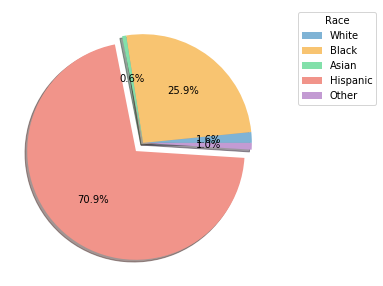

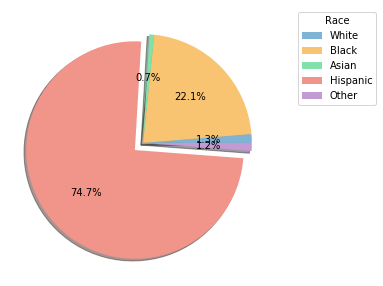

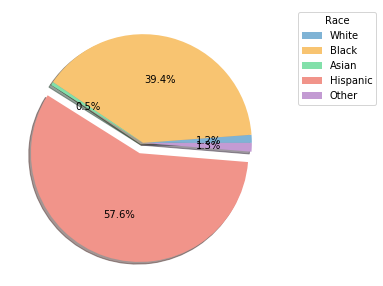

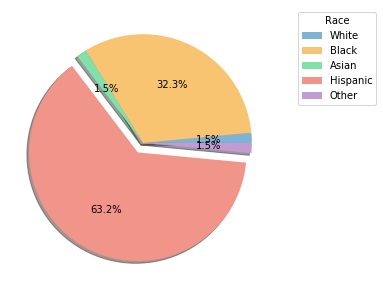

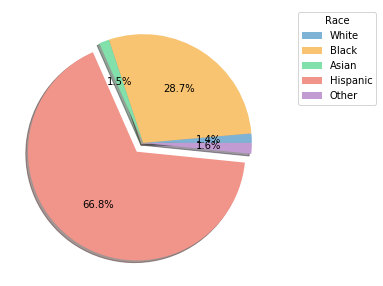

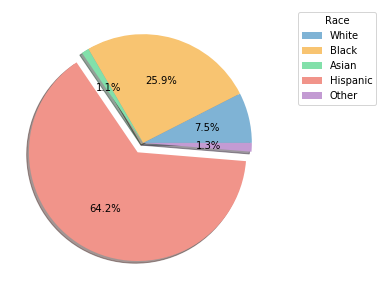

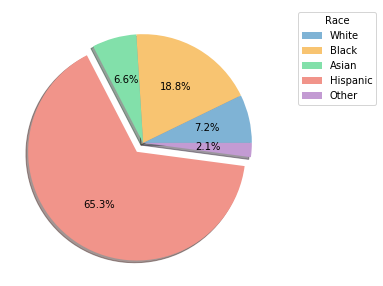

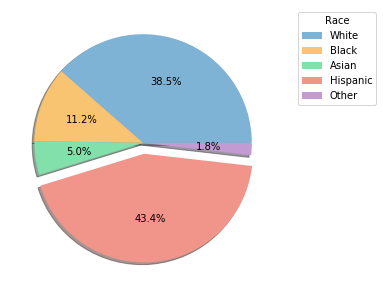

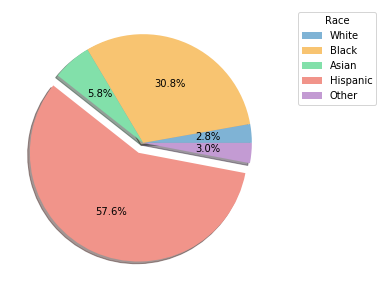

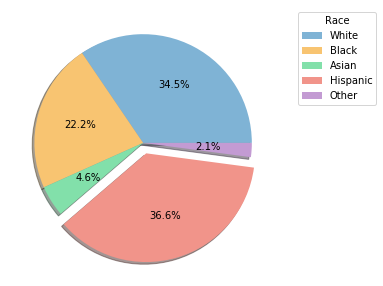

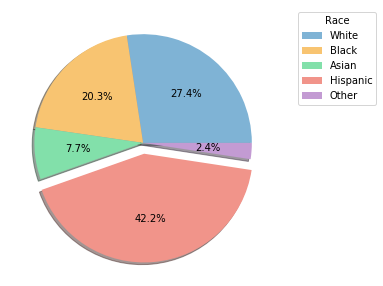

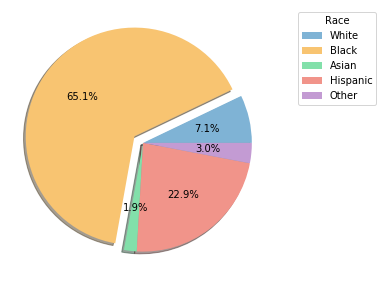

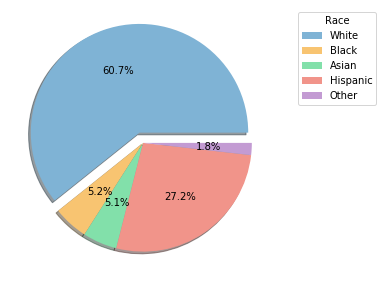

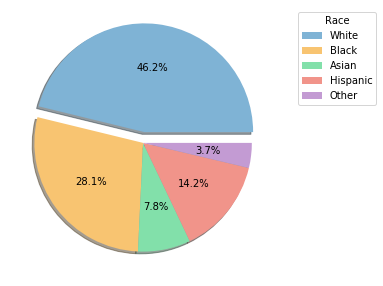

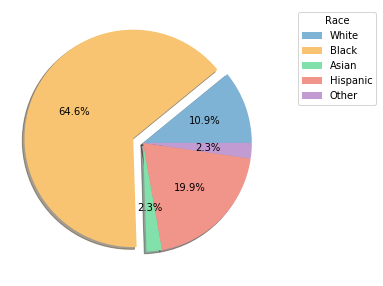

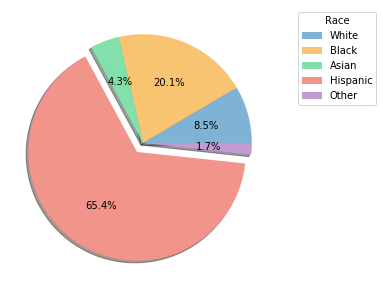

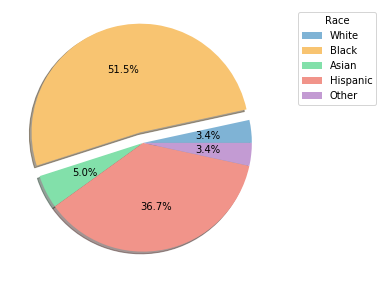

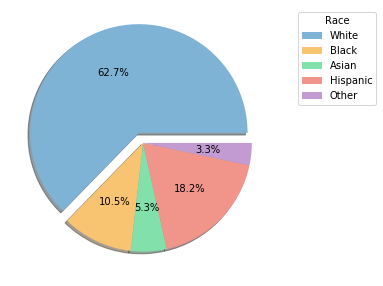

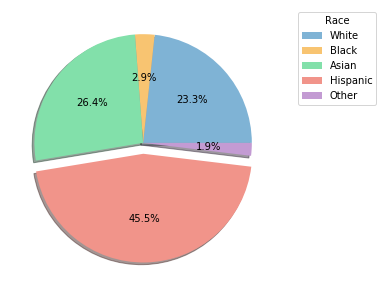

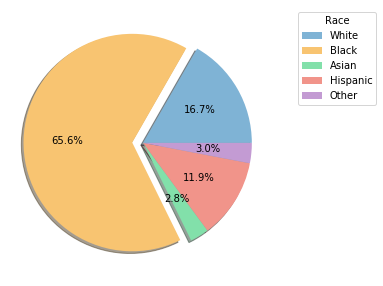

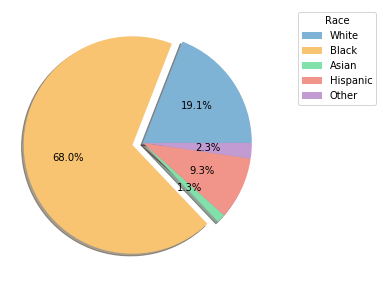

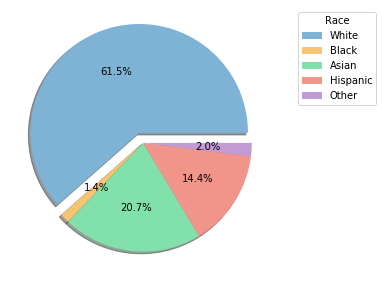

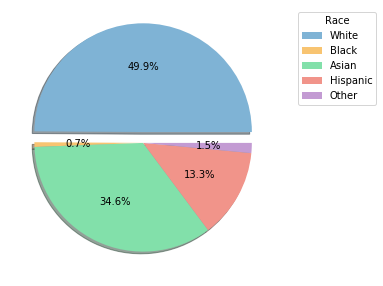

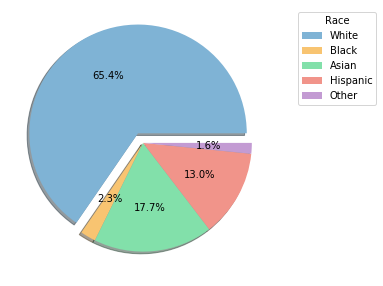

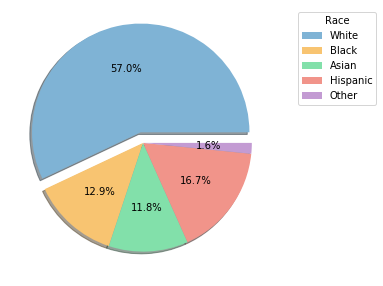

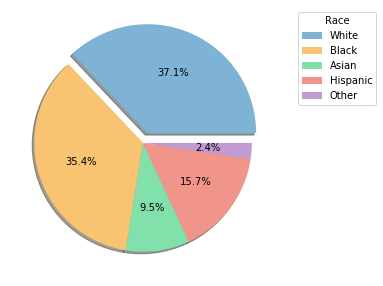

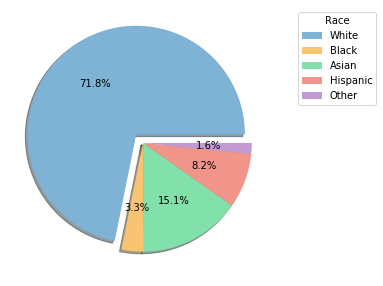

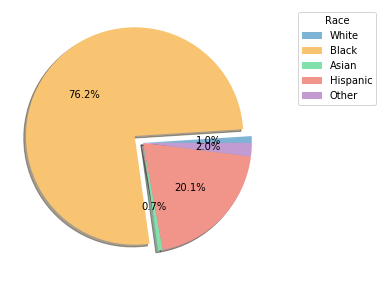

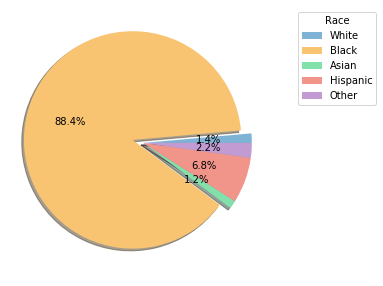

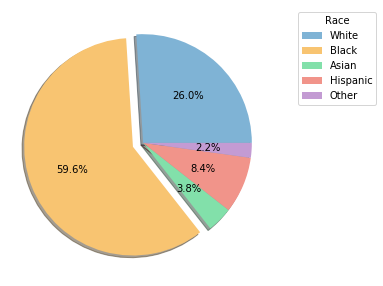

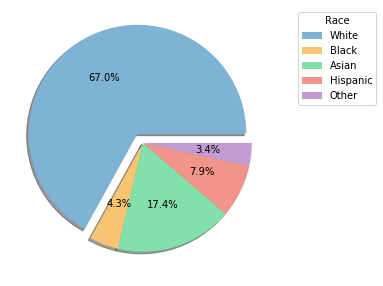

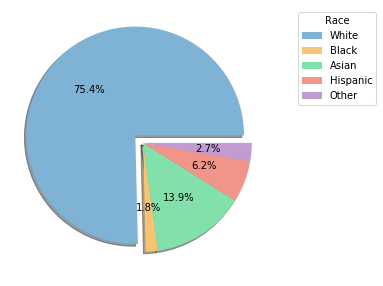

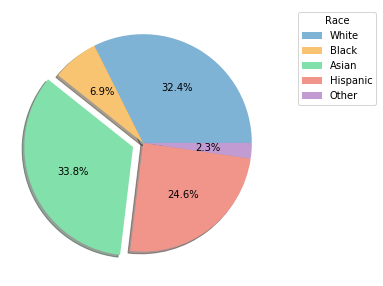

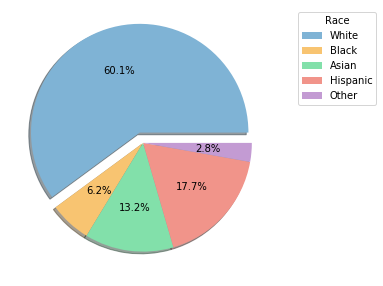

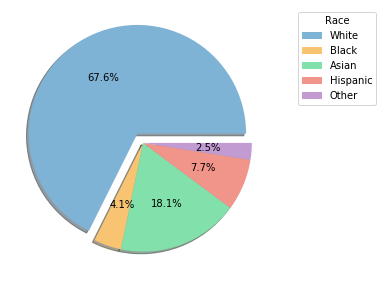

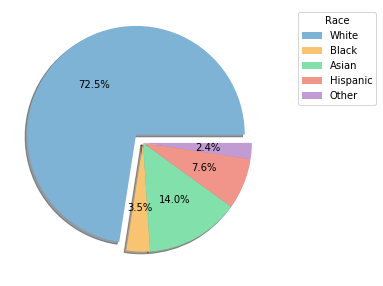

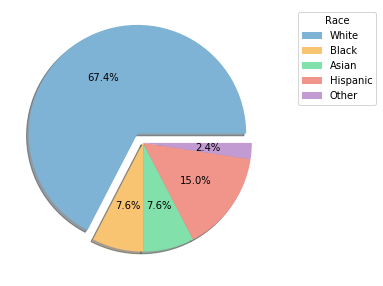

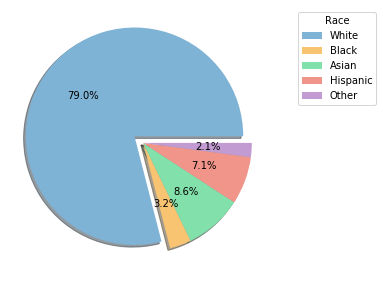

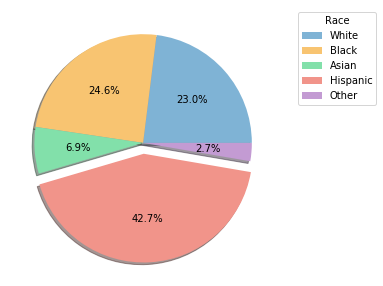

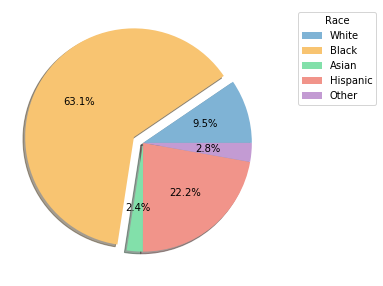

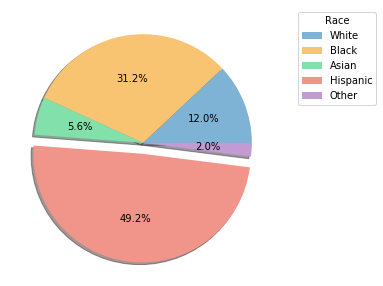

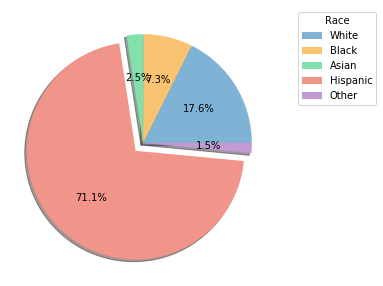

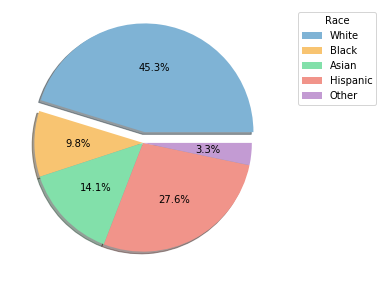

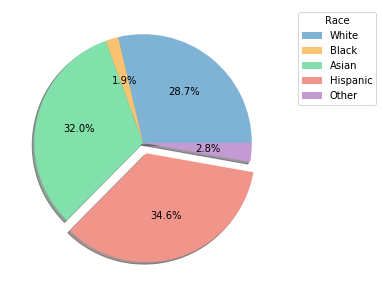

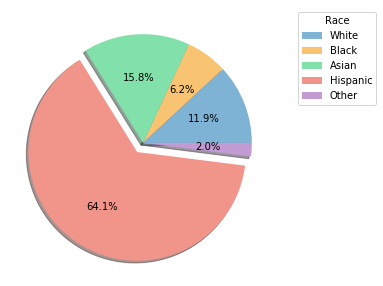

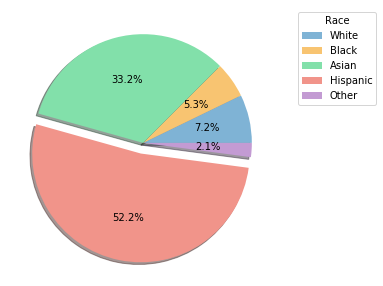

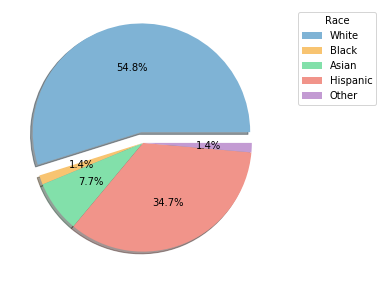

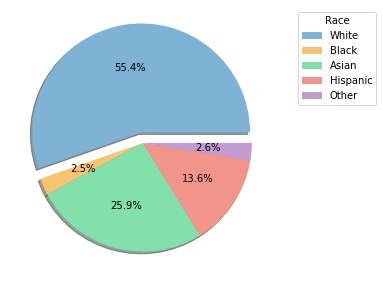

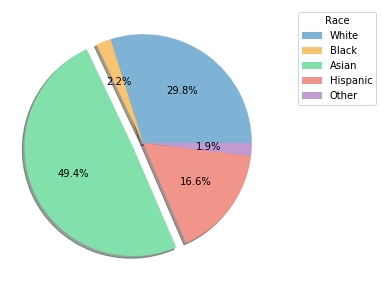

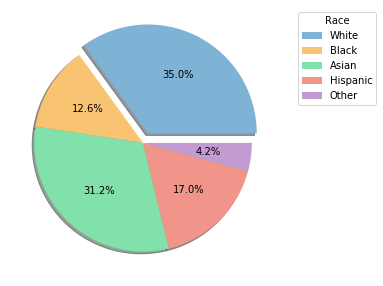

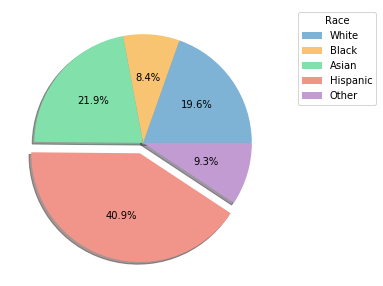

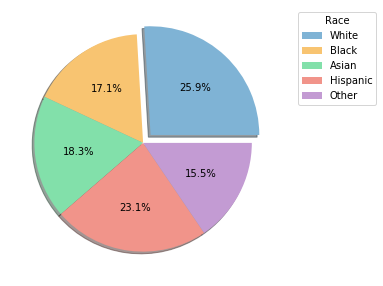

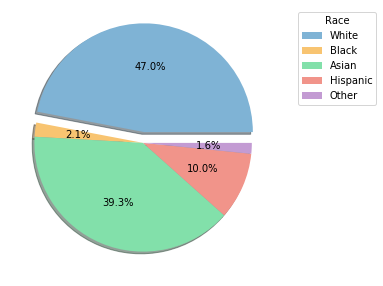

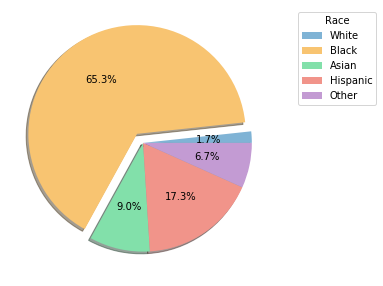

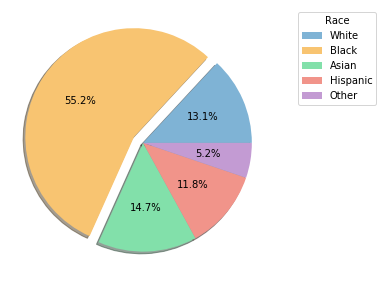

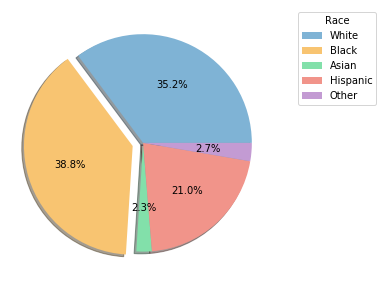

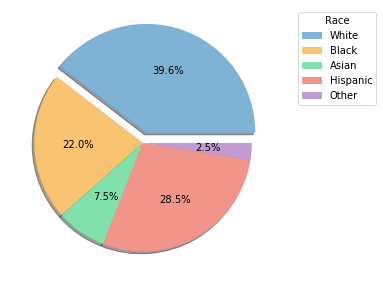

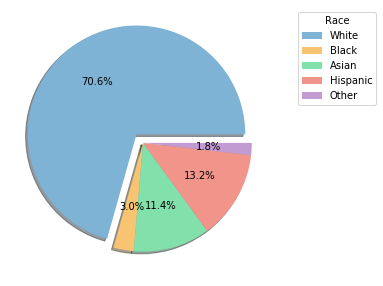

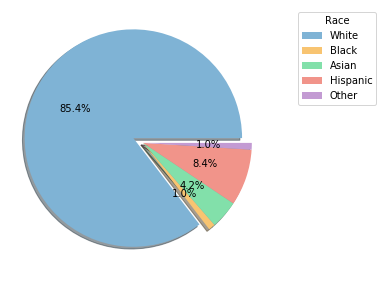

In [20]:
# Breakdown of race per community district
for i in range(0, 59):
    plt.figure(figsize=(5, 5))
    labels = ["White", "Black", "Asian", "Hispanic", "Other"]
    values = [float(frame_percentages.iloc[i, 1]), float(frame_percentages.iloc[i, 2]), float(frame_percentages.iloc[i, 3]),
              float(frame_percentages.iloc[i, 6]), float(frame_percentages.iloc[i, 4]) + float(frame_percentages.iloc[i, 5])]
    
    explode = (0, 0, 0, 0, 0)
    if max(values) == values[0]:
        explode = (0.1, 0, 0, 0, 0)
    elif max(values) == values[1]:
        explode = (0, 0.1, 0, 0, 0)
    elif max(values) == values[2]:
        explode = (0, 0, 0.1, 0, 0)
    elif max(values) == values[3]:
        explode = (0, 0, 0, 0.1, 0)
    else:
        explode = (0, 0, 0, 0, 0)
    
    colors = ['#7FB3D5', '#F8C471', '#82E0AA', '#F1948A', '#C39BD3']
    plt.pie(values, labels=labels, colors=colors, explode=explode, shadow=True, autopct="%.1f%%", labeldistance=None)
    plt.legend(bbox_to_anchor=(1.05, 1), title="Race")
    splitter = district_labels[i].split()
    plt.savefig("RaceViz/R" + str(splitter[0]) + str(splitter[-1]) +".png", bbox_inches='tight')


In [ ]:
# Gender per community district
for i in range(0, 59):
    plt.figure(figsize=(5, 5))
    labels = ["Female", "Male"]
    values = [frame_percentages.iloc[i, 7], frame_percentages.iloc[i, 8]]
    colors = ['#7FB3D5', '#F8C471']
    plt.pie(values, labels=labels, colors=colors, autopct="%.1f%%", labeldistance=None)
    plt.legend(bbox_to_anchor=(1.05, 1), title="Gender")
    splitter = district_labels[i].split()
    plt.savefig("GenderViz/G" + str(splitter[0]) + str(splitter[-1]) +".png", bbox_inches='tight')

In [ ]:
# Age per community district
for i in range(0, 59):
    plt.figure(figsize=(5, 5))
    labels = ["Under 5", "5 to 14", "15 to 24", "25 to 44", "45 to 64", "65+"]
    values = [float(frame_percentages.iloc[i, 9]), float(frame_percentages.iloc[i, 10]) + float(frame_percentages.iloc[i, 11]), 
              float(frame_percentages.iloc[i, 12]) + float(frame_percentages.iloc[i, 13]), float(frame_percentages.iloc[i, 14]),
              float(frame_percentages.iloc[i, 15]), float(frame_percentages.iloc[i, 16])]
    
    colors = ['#7FB3D5', '#F8C471', '#82E0AA', '#F1948A', '#C39BD3', '#BFC9CA']
    plt.pie(values, labels=labels, colors=colors, autopct="%.1f%%", labeldistance=None)
    plt.legend(bbox_to_anchor=(1.05, 1), title="Age")
    splitter = district_labels[i].split()
    plt.savefig("AgeViz/A" + str(splitter[0]) + str(splitter[-1]) +".png", bbox_inches='tight')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


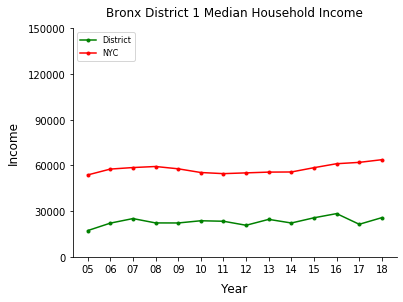

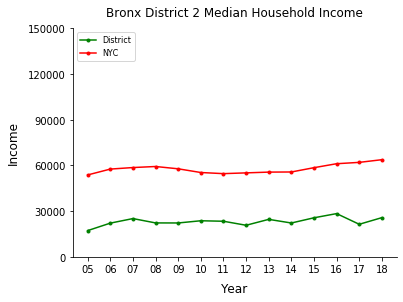

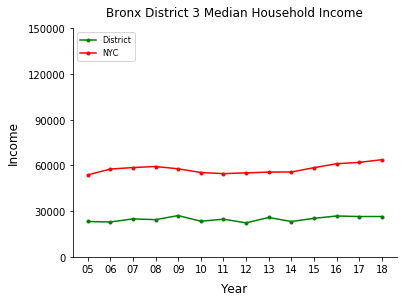

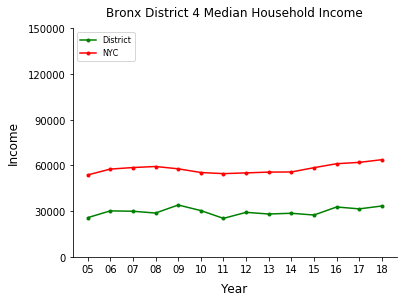

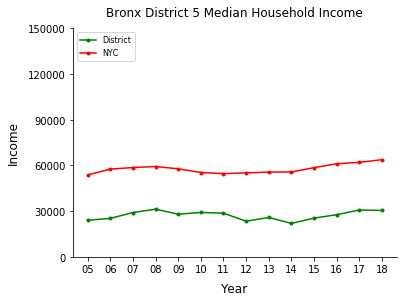

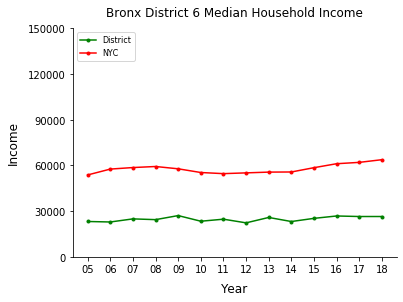

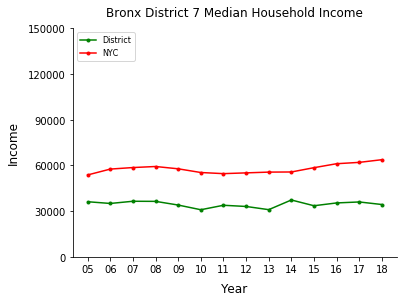

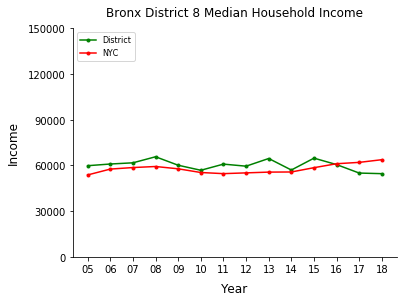

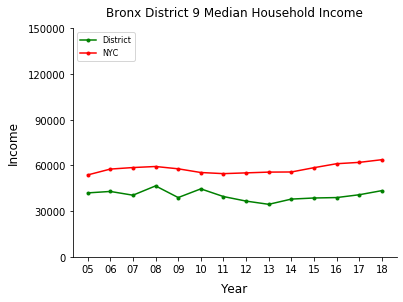

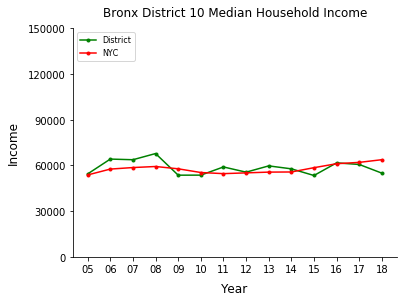

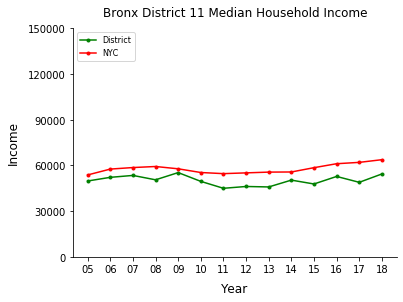

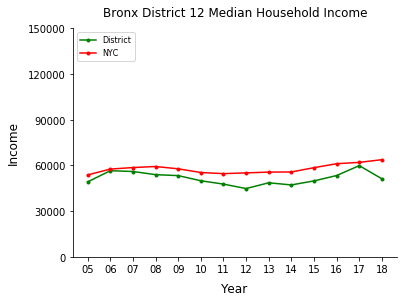

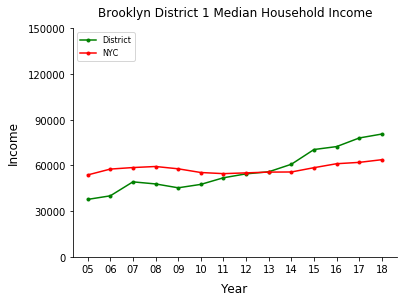

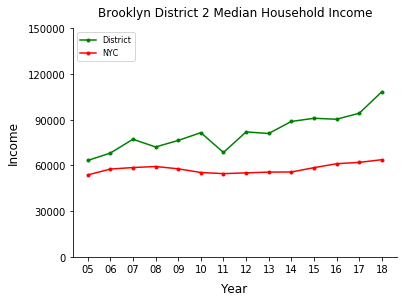

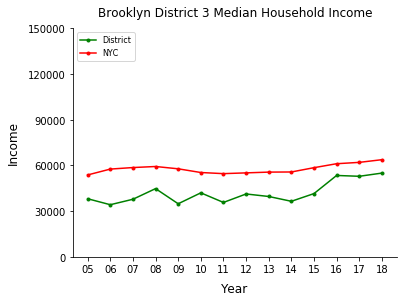

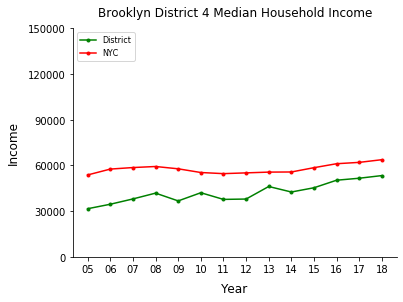

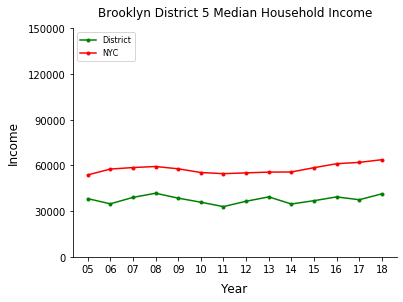

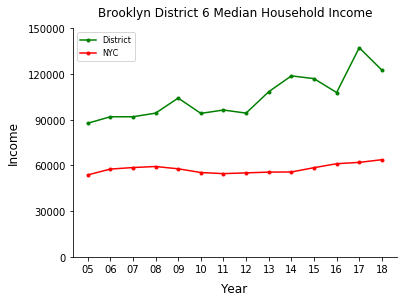

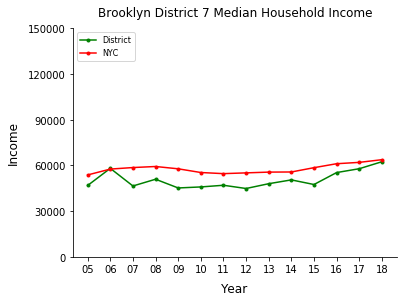

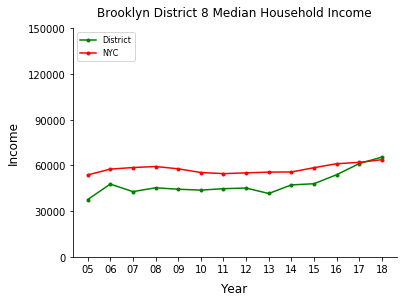

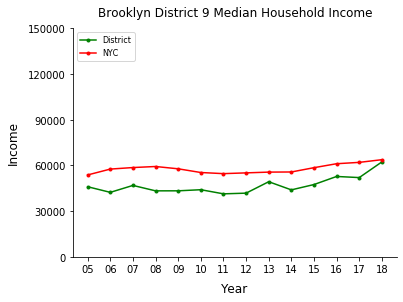

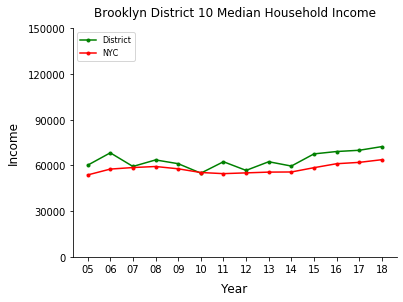

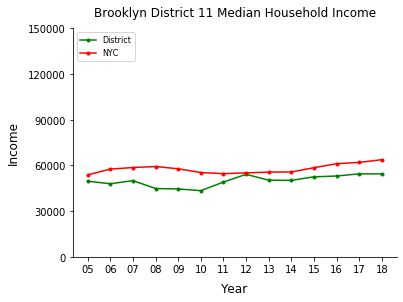

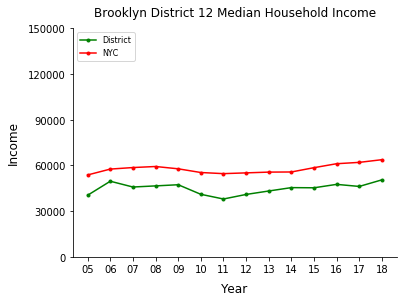

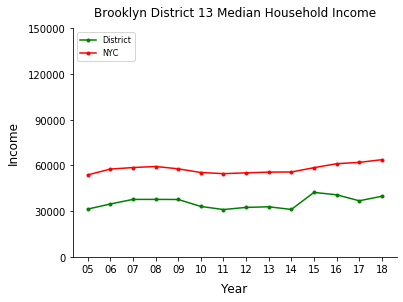

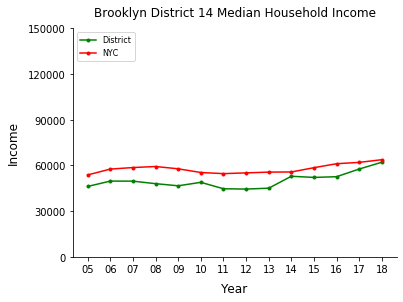

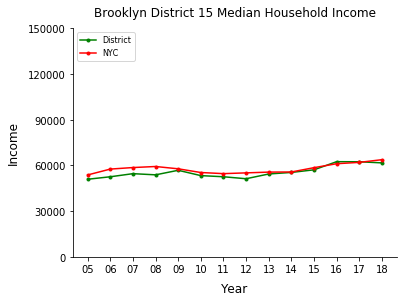

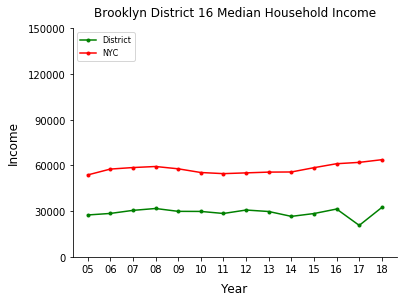

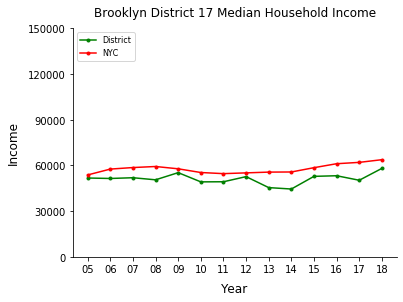

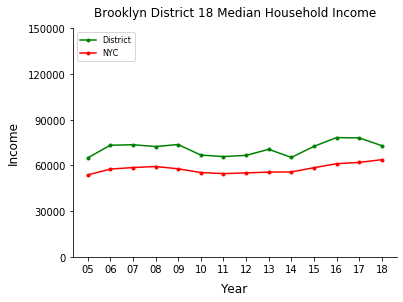

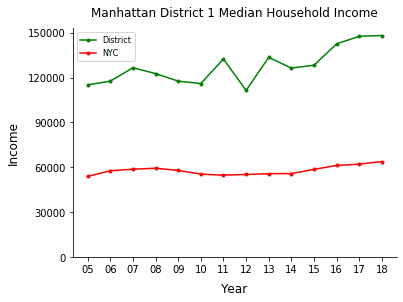

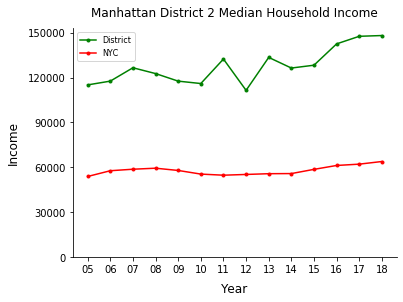

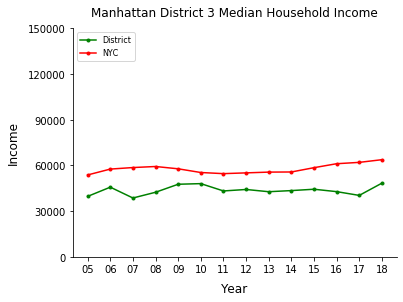

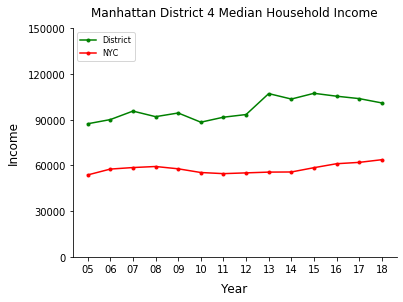

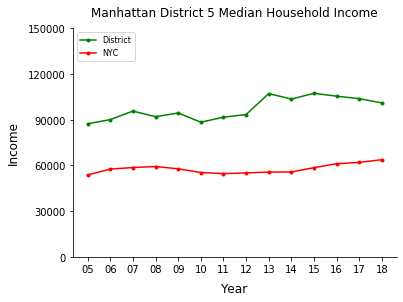

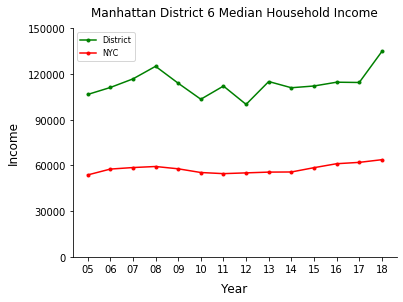

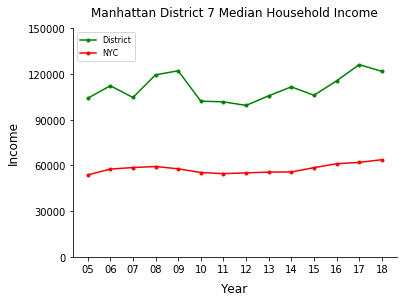

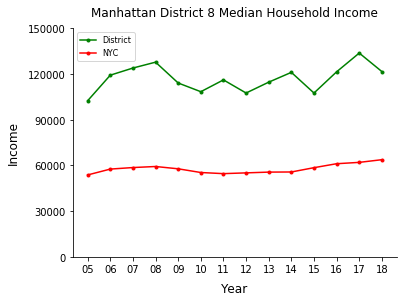

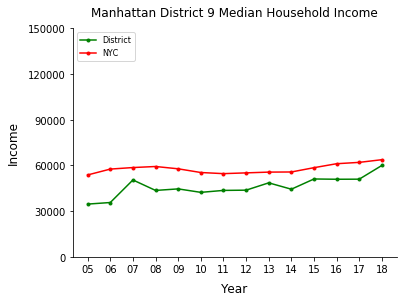

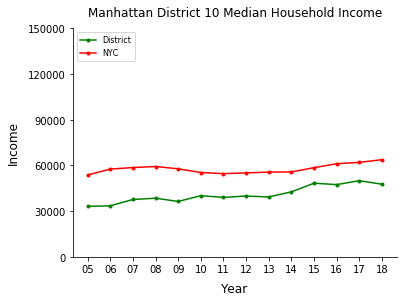

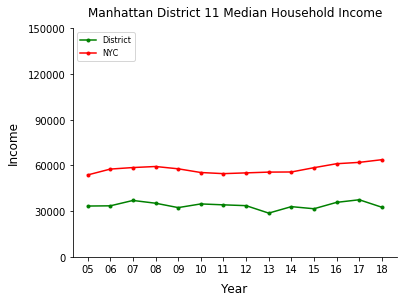

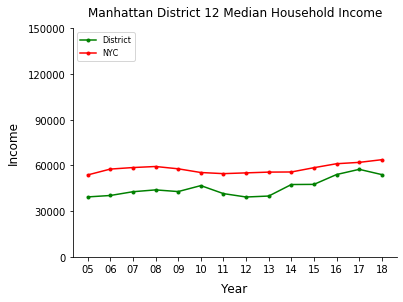

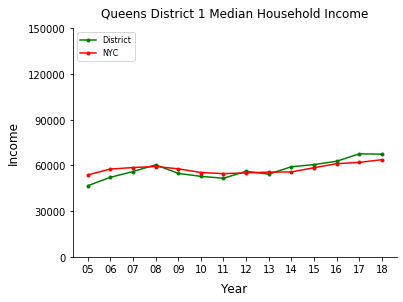

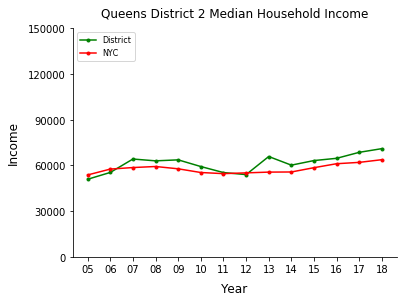

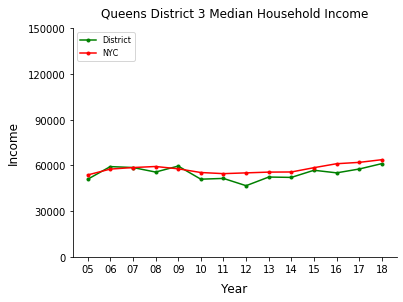

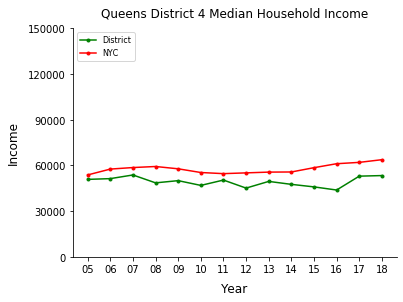

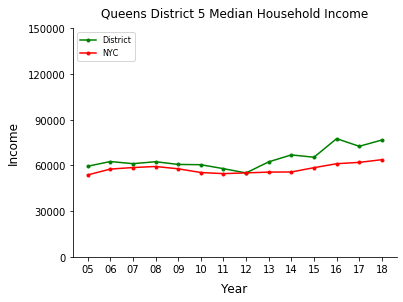

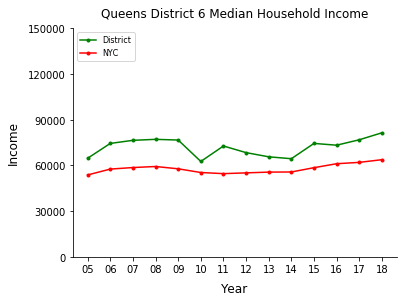

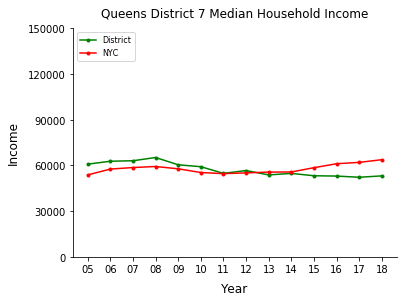

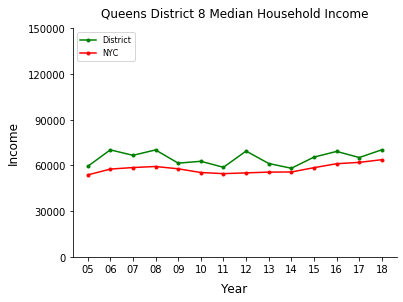

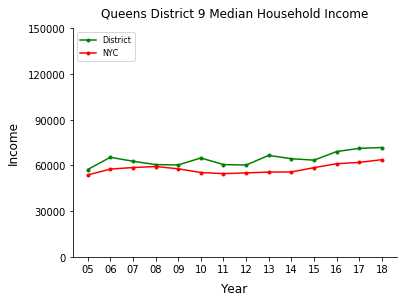

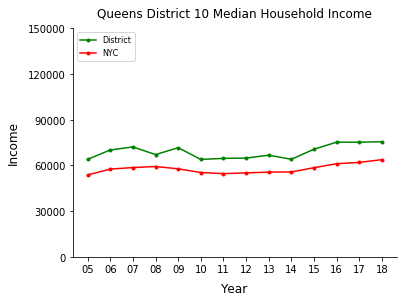

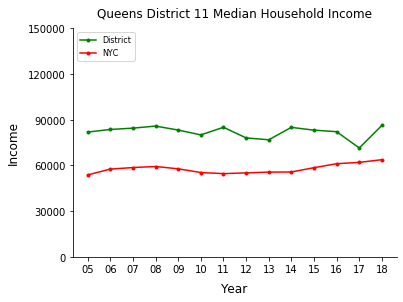

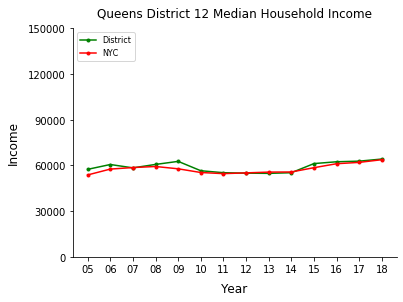

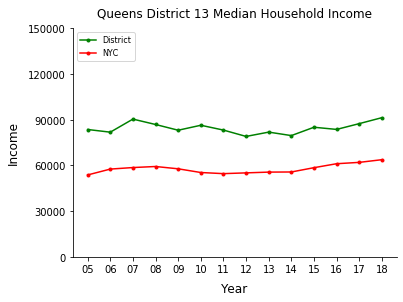

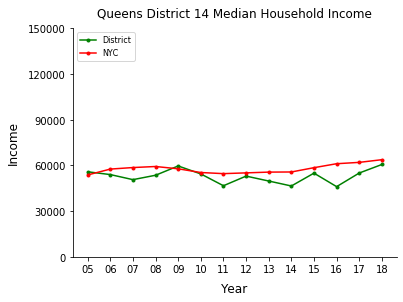

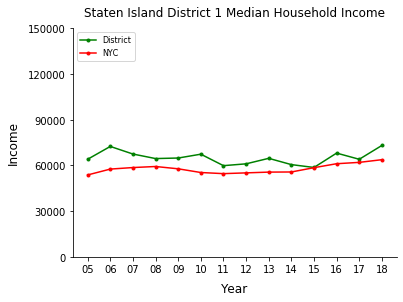

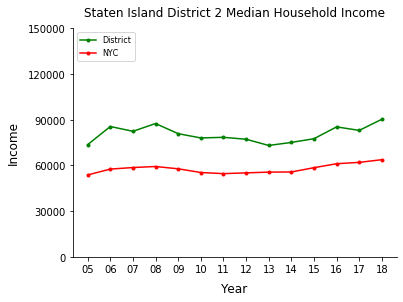

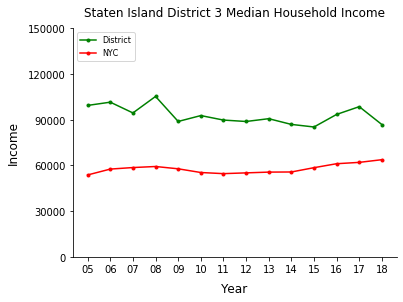

In [45]:
#Comparing median household income of NYC and each community district from 2005-2018 
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.titlepad'] = 12
mpl.rcParams['axes.titlesize'] = 12

for i in range(0, 59):
    plt.figure(figsize=(5.8, 4.2))
    plt.plot(household_income.iloc[i].index, household_income.iloc[i].values,'g.-', label='District')
    plt.plot(nyc_household_income.iloc[0].index, nyc_household_income.iloc[0].values,'r.-', label='NYC')
    plt.legend(loc='upper left')
    
    plt.xlabel('Year', fontsize=12, labelpad=8)
    plt.ylabel('Income', fontsize=12, labelpad=8)
    
    plt.yticks(np.arange(0, 160000, 30000))
    plt.title(district_labels[i] + ' Median Household Income')
    splitter = district_labels[i].split()
    plt.savefig("IncomeViz/I" + str(splitter[0]) + str(splitter[-1]) +".png", bbox_inches='tight')
    

**Transit Visualization**: we create line graphs to visualize arrests are summonses trends for each transit district.

In [ ]:
# Visualizing arrests by gender
for i in range(0,12): # Loop through each TD
    fig = plt.figure(figsize=(5, 5))
    # Save female columns
    values = [float(my_df3.iloc[i, 0]), float(my_df3.iloc[i, 1]), float(my_df3.iloc[i, 2]), 
             float(my_df3.iloc[i, 3]), float(my_df3.iloc[i, 4]), float(my_df3.iloc[i,5]), 
             float(my_df3.iloc[i,6])]
    # Save male columns
    values1 = [float(my_df3.iloc[i, 7]), float(my_df3.iloc[i, 8]), float(my_df3.iloc[i, 9]), 
              float(my_df3.iloc[i, 10]), float(my_df3.iloc[i, 11]), float(my_df3.iloc[i,12]),
              float(my_df3.iloc[i,13])]
    # Create plot axes, values, title, etc.
    plt.plot(values, label='Female')
    plt.plot(values1, label='Male')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0,100,200,300,400,500,600])
    plt.title('Arrests by Gender')
    plt.xlabel('Quarter')
    plt.legend(bbox_to_anchor=(1.29, 1.02), title="Gender") 
    # Save figure as PNG
    plt.savefig("chronologicalgraphs/ArrestsG" + str(i) + ".png", bbox_inches='tight') 
    

In [ ]:
# Create graphs for summonses by gender
for i in range(0,12): # Loop through each TD
    plt.figure(figsize=(5, 5))
    # Save female columns
    values = [float(my_ef3.iloc[i, 0]), float(my_ef3.iloc[i, 1]), float(my_ef3.iloc[i, 2]), 
              float(my_ef3.iloc[i, 3]), float(my_ef3.iloc[i, 4]), float(my_ef3.iloc[i,5]), float(my_ef3.iloc[i,6])]
    # Save male columns
    values1 = [float(my_ef3.iloc[i, 7]), float(my_ef3.iloc[i, 8]), float(my_ef3.iloc[i, 9]), 
              float(my_ef3.iloc[i, 10]), float(my_ef3.iloc[i, 11]), float(my_ef3.iloc[i,12]), float(my_ef3.iloc[i,13])]
    # Create plot axes, values, title, etc.
    plt.plot(values, label='Female')
    plt.plot(values1, label='Male')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0,200,400,600,800,1000,1200, 1400, 1600, 1800, 2000])
    plt.title('Summons by Gender')
    plt.xlabel('Quarter')
    plt.legend(bbox_to_anchor=(1.29, 1.02), title="Gender")
    # Save figure as PNG
    plt.savefig("chronologicalgraphs/summonsG" + str(i) + ".png", bbox_inches='tight')

In [ ]:
# Create graphs to view arrests per race
for i in range(0,12): # Loop through TD
    plt.figure(figsize=(5, 5))
    # Save race columns
    values0 = [float(ffs.iloc[i, 0]), float(ffs.iloc[i, 1]), float(ffs.iloc[i, 2]), float(ffs.iloc[i, 3]), 
               float(ffs.iloc[i, 4]), float(ffs.iloc[i,5]), float(ffs.iloc[i,6])]
    values1 = [float(ffs.iloc[i, 7]), float(ffs.iloc[i, 8]), float(ffs.iloc[i, 9]), float(ffs.iloc[i, 10]), 
               float(ffs.iloc[i, 11]), float(ffs.iloc[i,12]), float(ffs.iloc[i,13])]
    values2 = [float(ffs.iloc[i, 14]), float(ffs.iloc[i, 15]), float(ffs.iloc[i, 16]), float(ffs.iloc[i, 17]), 
               float(ffs.iloc[i, 18]), float(ffs.iloc[i,19]), float(ffs.iloc[i,20])]
    values3 = [float(ffs.iloc[i, 21]), float(ffs.iloc[i, 22]), float(ffs.iloc[i, 23]), float(ffs.iloc[i, 24]), 
               float(ffs.iloc[i, 25]), float(ffs.iloc[i,26]), float(ffs.iloc[i,27])] 
    values4 = [float(ffs.iloc[i, 28]), float(ffs.iloc[i, 29]), float(ffs.iloc[i, 30]), float(ffs.iloc[i, 31]), 
               float(ffs.iloc[i, 32]), float(ffs.iloc[i,33]), float(ffs.iloc[i,34])]
    # Create plot axes, values, title, etc.
    plt.plot(values0, label='American Indian')
    plt.plot(values1, label='Asian/Pac Isl')
    plt.plot(values2, label='Black')
    plt.plot(values3, label='Hispanic')
    plt.plot(values4, label='White')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325])
    plt.title('Arrests by Race')
    plt.xlabel('Quarter')
    plt.legend(bbox_to_anchor=(1, 1.02), title="Race")
    # Save figure as PNG
    plt.savefig("chronologicalgraphs/ArrestsR" + str(i) + ".png", bbox_inches='tight')

In [ ]:
# Create graphs to view summonses by race
for i in range(0,12): # Loop through TD
    plt.figure(figsize=(5, 5))
    # Save race columns
    values0 = [float(gfs.iloc[i, 0]), float(gfs.iloc[i, 1]), float(gfs.iloc[i, 2]), float(gfs.iloc[i, 3]), 
               float(gfs.iloc[i, 4]), float(gfs.iloc[i,5]), float(gfs.iloc[i,6])]
    values1 = [float(gfs.iloc[i, 7]), float(gfs.iloc[i, 8]), float(gfs.iloc[i, 9]), float(gfs.iloc[i, 10]), 
               float(gfs.iloc[i, 11]), float(gfs.iloc[i,12]), float(gfs.iloc[i,13])]
    values2 = [float(gfs.iloc[i, 14]), float(gfs.iloc[i, 15]), float(gfs.iloc[i, 16]), float(gfs.iloc[i, 17]), 
               float(gfs.iloc[i, 18]), float(gfs.iloc[i,19]), float(gfs.iloc[i,20])]
    values3 = [float(gfs.iloc[i, 21]), float(gfs.iloc[i, 22]), float(gfs.iloc[i, 23]), float(gfs.iloc[i, 24]), 
               float(gfs.iloc[i, 25]), float(gfs.iloc[i,26]), float(gfs.iloc[i,27])]
    values4 = [float(gfs.iloc[i, 28]), float(gfs.iloc[i, 29]), float(gfs.iloc[i, 30]), float(gfs.iloc[i, 31]), 
               float(gfs.iloc[i, 32]), float(gfs.iloc[i,33]), float(gfs.iloc[i,34])]
    # Create plot axes, values, title, etc.
    plt.plot(values0, label='American Indian')
    plt.plot(values1, label='Asian/Pac Isl')
    plt.plot(values2, label='Black')
    plt.plot(values3, label='Hispanic')
    plt.plot(values4, label='White')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000])
    plt.title('Summons by Race')
    plt.xlabel('Quarter')
    plt.legend(bbox_to_anchor=(1.45, 1.02), title="Race")
    # Save figure as PNG
    plt.savefig("chronologicalgraphs/SummonsR" + str(i) + ".png", bbox_inches='tight')

In [ ]:
# Create graphs to view arrests by age
for i in range(0,12): # Loop through every TD
    plt.figure(figsize=(5, 5))
    # Save age columns.
    values0 = [float(hfs.iloc[i, 0]), float(hfs.iloc[i, 1]), float(hfs.iloc[i, 2]), float(hfs.iloc[i, 3]), 
               float(hfs.iloc[i, 4]), float(hfs.iloc[i,5]), float(hfs.iloc[i,6])]
    values1 = [float(hfs.iloc[i, 7]), float(hfs.iloc[i, 8]), float(hfs.iloc[i, 9]), float(hfs.iloc[i, 10]), 
               float(hfs.iloc[i, 11]), float(hfs.iloc[i,12]), float(hfs.iloc[i,13])]
    values2 = [float(hfs.iloc[i, 14]), float(hfs.iloc[i, 15]), float(hfs.iloc[i, 16]), float(hfs.iloc[i, 17]), 
               float(hfs.iloc[i, 18]), float(hfs.iloc[i,19]), float(hfs.iloc[i,20])]
    values3 = [float(hfs.iloc[i, 21]), float(hfs.iloc[i, 22]), float(hfs.iloc[i, 23]), float(hfs.iloc[i, 24]), 
               float(hfs.iloc[i, 25]), float(hfs.iloc[i,26]), float(hfs.iloc[i,27])]
    values4 = [float(hfs.iloc[i, 28]), float(hfs.iloc[i, 29]), float(hfs.iloc[i, 30]), float(hfs.iloc[i, 31]), 
               float(hfs.iloc[i, 32]), float(hfs.iloc[i,33]), float(hfs.iloc[i,34])]
    # Create plot axes, values, title, etc.
    plt.plot(values0, label='10-17')
    plt.plot(values1, label='18-24')
    plt.plot(values2, label='25-40')
    plt.plot(values3, label='41-59')
    plt.plot(values4, label='60+')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325])
    plt.title('Arrests by Age')
    plt.xlabel('Quarter')
    plt.legend(bbox_to_anchor=(1.26, 1.02), loc='upper right', title="Age")
    # Save figure as PNG
    plt.savefig("chronologicalgraphs/ArrestsA" + str(i) + ".png", bbox_inches='tight')

In [ ]:
# Create graphs to view summons by age
for i in range(0,12): # Loop through TD
    plt.figure(figsize=(5, 5))
    # Save age columns
    values0 = [float(jfs.iloc[i, 0]), float(jfs.iloc[i, 1]), float(jfs.iloc[i, 2]), float(jfs.iloc[i, 3]), 
               float(jfs.iloc[i, 4]), float(jfs.iloc[i,5]), float(jfs.iloc[i,6])]
    values1 = [float(jfs.iloc[i, 7]), float(jfs.iloc[i, 8]), float(jfs.iloc[i, 9]), float(jfs.iloc[i, 10]), 
               float(jfs.iloc[i, 11]), float(jfs.iloc[i,12]), float(jfs.iloc[i,13])]
    values2 = [float(jfs.iloc[i, 14]), float(jfs.iloc[i, 15]), float(jfs.iloc[i, 16]), float(jfs.iloc[i, 17]), 
               float(jfs.iloc[i, 18]), float(jfs.iloc[i,19]), float(jfs.iloc[i,20])]
    values3 = [float(jfs.iloc[i, 21]), float(jfs.iloc[i, 22]), float(jfs.iloc[i, 23]), float(jfs.iloc[i, 24]), 
               float(jfs.iloc[i, 25]), float(jfs.iloc[i,26]), float(jfs.iloc[i,27])]
    values4 = [float(jfs.iloc[i, 28]), float(jfs.iloc[i, 29]), float(jfs.iloc[i, 30]), float(jfs.iloc[i, 31]), 
               float(jfs.iloc[i, 32]), float(jfs.iloc[i,33]), float(jfs.iloc[i,34])]
    # Create plot axes, values, title, etc.
    plt.plot(values0, label='10-17')
    plt.plot(values1, label='18-24')
    plt.plot(values2, label='25-40')
    plt.plot(values3, label='41-59')
    plt.plot(values4, label='60+')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0, 200, 400, 600, 800, 1000, 1200, 1400])
    plt.title('Summons by Age')
    plt.xlabel('Quarter')
    plt.legend(bbox_to_anchor=(1.26, 1.02), loc='upper right', title="Age")
    # Save figure as PNG
    plt.savefig("chronologicalgraphs/SummonsA" + str(i) + ".png", bbox_inches='tight')